# Predicting Fishing Habits to Identify Illegal Fishing Activity

## Overview of Process - CRISP-DM
1. Business Understanding 
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

# 1. Business Understanding
According to NOAA, "illegal, unreported, and unregulated fishing activities (`IUU`) violate both national and international fishing regulations. IUU is a global problem that threatens ocean ecosystems and sustainable fisheries.  It also threatens economic secuity and the natural resources that are critical to global food security. IUU also puts law-abiding fishing operations at a disadvantage."

While the ramifications of unregulated and illegal fishing operations are fairly clear, monitoring the open oceans is less clear.  Vast areas of open ocean and limited resources makes physical surveillance and monitoring of protected fishing areas impractical.  A classifier that is able to tag vessels based on current fishing status would enable policy makers and regulators to keep a better watch on fishing fleets.  Additionally, vessels tagged as fishing could have location cross-referenced with protected marine areas and illegal fishing zones to further identify illegal fishing activity.  

AIS stands for Automatic Identification System, and is used for tracking marine vessel traffic data. AIS data is collected by the US Coast Guard through an onboard safety navigation device that transmits and monitors the location and characteristics of large vessels in the US and international waters in real time. In the United States, the Coast Guard and commercial vendors collect AIS data, which can also be used for a variety of coastal planning initiatives. https://marinecadastre.gov/ais/

AIS is a maritime navigation safety communications system standardized by the international telecommunications union and adopted by the International Maritime Organization (IMO) that provides vessel information, including the vessel's identity, type, position, course, speed, navigational status and other safety-related information automatically to appropriately equipped shore stations, other ships, and aircraft; receives automatically such information from similarly fitted ships; monitors and tracks ships; and exchanges data with shore-based facilities. More information can be found here https://www.navcen.uscg.gov/?pageName=AISFAQ#1

In addition to AIS data, vessels likely make decisions based on current water conditions, as these conditions impact their ultimate supply of fish.  Coupling AIS data with public ocean information like depth, salinity measurements, etc. will hopefully provide strong classification results. 

In conclusion, AIS data will be merged with Ocean Station Data to build a classifier that is able to determine whether or not a vessel is fishing. 

# 2. Data Understanding

1. What data is available to us? Where does it come from?
2. Who controls the data and what steps are needed to access the data?
3. What is our target?
4. What predictors are available to us?
5. What data types are the predictors?
6. What is the distribution of our data?
7. How big is our data?
8. Do we have enough data to build a model? Will we need to use resampling?
9. How do we know the data is correct?  Is there a chance the data is wrong?

Two primary datasets will be used for this process:
1. Vessel AIS data sourced from Global Fishing Watch
2. Various ocean measurements and Ocean Station Data sourced from NOAA and the World Ocean Database

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import time

# set visualization style
plt.style.use('ggplot')

## AIS Data (Global Fishing Watch)
Global fishing watch dataset was sourced from `https://globalfishingwatch.org/data-download/`. 7 separate files were downloaded, each corresponding to a type of fishing vessel:
1. `drifting_longlines.csv`
2. `fixed_gear.csv`
3. `pole_and_line.csv`
4. `purse_seines.csv`
5. `trawlers.csv`
6. `trollers.csv`
7. `unknown.csv`

In [2]:
# load datasets
drifting_longlines = pd.read_csv('data/drifting_longlines.csv')
fixed_gear = pd.read_csv('data/fixed_gear.csv')
pole_and_line = pd.read_csv('data/pole_and_line.csv')
purse_seines = pd.read_csv('data/purse_seines.csv')
trawlers = pd.read_csv('data/trawlers.csv')
trollers = pd.read_csv('data/trollers.csv')
unknown = pd.read_csv('data/unknown.csv')

Per Global Fishing Watch each dataset contains the following columns:
* `mmsi` - anonymized vessel identifier
* `timestamp` - unix timestamp
* `distance_from_shore` - distance from shore in meters
* `distance_from_port` - distance from port in meters
* `speed` - vessel speed in knots
* `course` - vessel course
* `lat` - latitude in decimal degrees
* `long` - longitude in decimal degrees
* `source` - The training data batch. Data was prepared by GFW, Dalhousie, and a crowd sourcing campaign. False positives are marked as false_positives
* `vessel_type` - type of vessel
* `is_fishing` - label indicating fishing activity
    * `0` = not fishing
    * `>0` = fishing. Data values between 0 and 1 indicate the average score for the position if scored by multiple people
    * `-1` = no data. 
    
`is_fishing` will be our primary target variable, with other columns available to us used as features. 

### AIS - Drifting Longlines

In [3]:
# display top 5 rows
drifting_longlines.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.263956e+13,1.327137e+09,232994.281250,311748.65625,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner
1,1.263956e+13,1.327137e+09,233994.265625,312410.34375,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner
2,1.263956e+13,1.327137e+09,233994.265625,312410.34375,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner
3,1.263956e+13,1.327143e+09,233994.265625,315417.37500,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner
4,1.263956e+13,1.327143e+09,233996.390625,316172.56250,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner


In [4]:
# display info
drifting_longlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13968727 entries, 0 to 13968726
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
dtypes: float64(9), object(1)
memory usage: 1.0+ GB


In [5]:
# display summary statistics for continuous columns
drifting_longlines.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.396873e+07,1.396873e+07,1.396873e+07,1.396873e+07,1.396863e+07,1.396863e+07,1.396873e+07,1.396873e+07,1.396873e+07
mean,1.293850e+14,1.434290e+09,5.845311e+05,7.897505e+05,5.464779e+00,1.814876e+02,-8.997629e+00,3.758693e+00,-9.743015e-01
std,7.887357e+13,3.984275e+07,5.420068e+05,6.915438e+05,4.043567e+00,1.050503e+02,2.439311e+01,1.095971e+02,2.119947e-01
min,5.601266e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.519017e+01,-1.800000e+02,-1.000000e+00
25%,6.260384e+13,1.410706e+09,1.019092e+05,2.130206e+05,2.100000e+00,9.070000e+01,-2.601550e+01,-8.808668e+01,-1.000000e+00
50%,1.184859e+14,1.447302e+09,4.576393e+05,6.375249e+05,5.500000e+00,1.811000e+02,-1.497954e+01,-1.716495e+00,-1.000000e+00
75%,1.980758e+14,1.466506e+09,9.603664e+05,1.210432e+06,8.500000e+00,2.711000e+02,4.485790e+00,1.009811e+02,-1.000000e+00
max,2.812058e+14,1.480032e+09,4.430996e+06,7.181037e+06,1.023000e+02,5.110000e+02,8.333266e+01,1.799938e+02,1.000000e+00


In [6]:
# display number of unique vessels
drifting_longline_ids = drifting_longlines['mmsi'].unique()
print(f'There are {len(drifting_longline_ids)} unique anonymized vessel IDs')

There are 110 unique anonymized vessel IDs


### AIS - Fixed Gear

In [7]:
# display top 5 rows
fixed_gear.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.572519e+12,1.347664e+09,0.0,36054.625000,0.0,0.000000,42.798748,-8.944992,-1.0,gfw
1,7.572519e+12,1.348056e+09,0.0,36054.625000,0.0,0.000000,42.798717,-8.945075,-1.0,gfw
2,7.572519e+12,1.350409e+09,0.0,90970.296875,0.0,198.199997,43.106419,-9.215466,-1.0,gfw
3,7.572519e+12,1.350410e+09,0.0,90970.296875,0.0,186.899994,43.106434,-9.215431,-1.0,gfw
4,7.572519e+12,1.350411e+09,0.0,90970.296875,0.0,190.500000,43.106430,-9.215442,-1.0,gfw


In [8]:
# display info
fixed_gear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559137 entries, 0 to 1559136
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   mmsi                 1559137 non-null  float64
 1   timestamp            1559137 non-null  float64
 2   distance_from_shore  1559137 non-null  float64
 3   distance_from_port   1559137 non-null  float64
 4   speed                1559137 non-null  float64
 5   course               1559137 non-null  float64
 6   lat                  1559137 non-null  float64
 7   lon                  1559137 non-null  float64
 8   is_fishing           1559137 non-null  float64
 9   source               1559137 non-null  object 
dtypes: float64(9), object(1)
memory usage: 119.0+ MB


In [9]:
# display summary stats for cont. columns
fixed_gear.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06
mean,1.530752e+14,1.421486e+09,3.761878e+04,5.989848e+04,2.227195e+00,1.877938e+02,5.095086e+01,1.274018e+00,-9.659100e-01
std,8.976383e+13,3.782830e+07,1.090188e+05,1.269729e+05,3.412790e+00,1.177506e+02,5.894565e+00,8.512244e+00,2.173124e-01
min,7.572519e+12,1.325625e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.326460e+01,-1.792441e+02,-1.000000e+00
25%,8.878018e+13,1.387594e+09,0.000000e+00,5.656715e+03,0.000000e+00,7.740000e+01,4.745566e+01,-3.909275e+00,-1.000000e+00
50%,1.305289e+14,1.427254e+09,0.000000e+00,2.690659e+04,1.000000e-01,2.055000e+02,5.050242e+01,-2.333808e+00,-1.000000e+00
75%,2.616830e+14,1.455255e+09,3.413126e+04,5.514391e+04,3.800000e+00,2.870000e+02,5.602126e+01,8.220293e+00,-1.000000e+00
max,2.802913e+14,1.480032e+09,3.099833e+06,1.181676e+07,1.023000e+02,5.110000e+02,8.479108e+01,1.709277e+02,1.000000e+00


In [10]:
# display number of unique vessels
fixed_gear_ids = fixed_gear['mmsi'].unique()
print(f'There are {len(fixed_gear_ids)} unique anonymized vessel IDs')

There are 36 unique anonymized vessel IDs


### AIS - Pole and Line

In [11]:
# display top 5 rows
pole_and_line.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.848346e+13,1.340882e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537797,-1.0,gfw
1,1.848346e+13,1.340884e+09,0.000000,2236.013184,0.0,125.199997,28.967373,-13.537838,-1.0,gfw
2,1.848346e+13,1.340885e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
3,1.848346e+13,1.340888e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
4,1.848346e+13,1.340925e+09,1999.950928,2828.357666,8.7,203.100006,28.929653,-13.543955,-1.0,gfw


In [12]:
# display info
pole_and_line.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161315 entries, 0 to 161314
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   mmsi                 161315 non-null  float64
 1   timestamp            161315 non-null  float64
 2   distance_from_shore  161315 non-null  float64
 3   distance_from_port   161315 non-null  float64
 4   speed                161315 non-null  float64
 5   course               161315 non-null  float64
 6   lat                  161315 non-null  float64
 7   lon                  161315 non-null  float64
 8   is_fishing           161315 non-null  float64
 9   source               161315 non-null  object 
dtypes: float64(9), object(1)
memory usage: 12.3+ MB


In [13]:
# display summary stats for cont columns
pole_and_line.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.613150e+05,1.613150e+05,1.613150e+05,1.613150e+05,161315.000000,161315.000000,161315.000000,161315.000000,161315.000000
mean,7.659841e+13,1.414174e+09,4.894434e+04,7.383040e+04,2.111584,132.245911,33.456753,-4.570087,-0.967918
std,5.740577e+13,4.300647e+07,2.036499e+05,2.333604e+05,3.696588,117.424918,5.665633,53.524248,0.205442
min,1.848346e+13,1.327882e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-41.853848,-70.921013,-1.000000
25%,1.848346e+13,1.368384e+09,0.000000e+00,2.236013e+03,0.000000,3.300000,28.965940,-28.527719,-1.000000
50%,8.703142e+13,1.423536e+09,0.000000e+00,1.442185e+04,0.000000,115.199997,33.029419,-16.734444,-1.000000
75%,8.703142e+13,1.456109e+09,2.280295e+04,5.324341e+04,1.800000,228.699997,38.531128,-13.539565,-1.000000
max,2.145727e+14,1.480031e+09,2.110362e+06,3.005100e+06,102.300003,360.000000,77.078987,177.632980,1.000000


In [14]:
# number of unique vessels
pole_and_line_ids = pole_and_line['mmsi'].unique()
print(f'There are {len(pole_and_line_ids)} unique anonymized vessel IDs')

There are 6 unique anonymized vessel IDs


### AIS - Purse Seines

In [15]:
# display top 5 rows
purse_seines.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,9.924005e+12,1.379601e+09,0.0,1414.178833,0.0,298.500000,8.861500,-79.668427,-1.0,false_positives
1,9.924005e+12,1.379602e+09,0.0,1414.178833,0.0,298.500000,8.861506,-79.668442,-1.0,false_positives
2,9.924005e+12,1.379604e+09,0.0,1414.178833,0.1,128.399994,8.861511,-79.668488,-1.0,false_positives
3,9.924005e+12,1.379605e+09,0.0,1414.178833,0.1,111.199997,8.861511,-79.668480,-1.0,false_positives
4,9.924005e+12,1.379608e+09,0.0,1414.178833,0.0,41.700001,8.861502,-79.668503,-1.0,false_positives


In [16]:
# display info
purse_seines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545323 entries, 0 to 1545322
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   mmsi                 1545323 non-null  float64
 1   timestamp            1545323 non-null  float64
 2   distance_from_shore  1545323 non-null  float64
 3   distance_from_port   1545323 non-null  float64
 4   speed                1545316 non-null  float64
 5   course               1545316 non-null  float64
 6   lat                  1545323 non-null  float64
 7   lon                  1545323 non-null  float64
 8   is_fishing           1545323 non-null  float64
 9   source               1545323 non-null  object 
dtypes: float64(9), object(1)
memory usage: 117.9+ MB


In [17]:
# summary stats for cont. columns
purse_seines.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.545323e+06,1.545323e+06,1.545323e+06,1.545323e+06,1.545316e+06,1.545316e+06,1.545323e+06,1.545323e+06,1.545323e+06
mean,8.788081e+13,1.431543e+09,2.301199e+05,3.420745e+05,5.119294e+00,1.905941e+02,1.390564e+01,1.472753e+01,-9.833250e-01
std,6.522389e+13,3.645865e+07,3.841463e+05,5.070968e+05,5.593512e+00,1.042562e+02,1.891573e+01,1.116258e+02,1.418592e-01
min,9.924005e+12,1.325378e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.922275e+01,-1.800000e+02,-1.000000e+00
25%,3.832297e+13,1.409017e+09,0.000000e+00,8.062060e+03,1.000000e-01,9.820000e+01,-4.091158e-01,-7.966909e+01,-1.000000e+00
50%,5.966517e+13,1.438458e+09,4.049592e+04,9.693059e+04,1.300000e+00,2.034000e+02,5.338995e+00,-1.897600e+00,-1.000000e+00
75%,1.583170e+14,1.462147e+09,2.866600e+05,4.934421e+05,1.120000e+01,2.791000e+02,3.510037e+01,1.410436e+02,-1.000000e+00
max,2.679667e+14,1.480032e+09,2.315626e+06,6.728604e+06,1.023000e+02,5.110000e+02,7.833025e+01,1.799934e+02,1.000000e+00


In [18]:
# number of unique vessels
purse_seine_ids = purse_seines['mmsi'].unique()
print(f'There are {len(purse_seine_ids)} unique anonymized vessel IDs')

There are 28 unique anonymized vessel IDs


### AIS - Trawlers

In [19]:
# display top 5 rows
trawlers.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw
3,1.252340e+12,1.325380e+09,0.0,0.0,0.0,153.0,52.458649,4.581234,-1.0,gfw
4,1.252340e+12,1.325381e+09,0.0,0.0,0.0,153.0,52.458649,4.581183,-1.0,gfw


In [20]:
# display info
trawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369101 entries, 0 to 4369100
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
dtypes: float64(9), object(1)
memory usage: 333.3+ MB


In [21]:
# summary stats for cont. columns
trawlers.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,4.369101e+06,4.369101e+06,4.369101e+06,4.369101e+06,4.369023e+06,4.369023e+06,4.369101e+06,4.369101e+06,4.369101e+06
mean,1.578952e+14,1.426220e+09,7.819802e+04,1.496648e+05,2.972401e+00,1.744043e+02,3.266757e+01,4.927771e+00,-9.449078e-01
std,9.494779e+13,3.876472e+07,2.040747e+05,3.279532e+05,4.105081e+00,1.154701e+02,3.837240e+01,8.127552e+01,2.844518e-01
min,1.252340e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.498024e+01,-1.799996e+02,-1.000000e+00
25%,7.726193e+13,1.397205e+09,0.000000e+00,2.236013e+03,0.000000e+00,6.480000e+01,3.623107e+01,-8.288531e+00,-1.000000e+00
50%,1.753874e+14,1.434811e+09,4.242537e+03,3.605462e+04,1.500000e+00,1.870000e+02,5.209994e+01,4.584417e+00,-1.000000e+00
75%,2.402260e+14,1.458922e+09,5.578393e+04,9.608094e+04,4.500000e+00,2.760000e+02,5.463578e+01,1.432063e+01,-1.000000e+00
max,2.775153e+14,1.480032e+09,3.257453e+06,1.245220e+07,1.023000e+02,5.110000e+02,8.461642e+01,1.799934e+02,1.000000e+00


In [22]:
# number of unique vessels
trawlers_ids = trawlers['mmsi'].unique()
print(f'There are {len(trawlers_ids)} unique anonymized vessel IDs')

There are 49 unique anonymized vessel IDs


### AIS - Trollers

In [23]:
# display top 5 rows
trollers.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.652701e+13,1.337836e+09,0.0,3162.200195,0.0,0.000000,51.887592,4.356583,-1.0,gfw
1,7.652701e+13,1.338199e+09,0.0,4999.877441,0.0,0.000000,51.242130,4.403008,-1.0,gfw
2,7.652701e+13,1.343752e+09,0.0,66308.250000,8.6,292.200012,51.960873,5.196125,-1.0,gfw
3,7.652701e+13,1.350795e+09,0.0,15296.682617,0.0,0.000000,51.231094,4.526647,-1.0,gfw
4,7.652701e+13,1.351808e+09,0.0,15296.682617,0.0,0.000000,51.231098,4.526487,-1.0,gfw


In [24]:
# display info
trollers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166243 entries, 0 to 166242
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   mmsi                 166243 non-null  float64
 1   timestamp            166243 non-null  float64
 2   distance_from_shore  166243 non-null  float64
 3   distance_from_port   166243 non-null  float64
 4   speed                166243 non-null  float64
 5   course               166243 non-null  float64
 6   lat                  166243 non-null  float64
 7   lon                  166243 non-null  float64
 8   is_fishing           166243 non-null  float64
 9   source               166243 non-null  object 
dtypes: float64(9), object(1)
memory usage: 12.7+ MB


In [25]:
# summary stats of cont. columns
trollers.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.662430e+05,1.662430e+05,166243.000000,1.662430e+05,166243.000000,166243.000000,166243.000000,166243.000000,166243.000000
mean,1.486917e+14,1.426558e+09,5116.678753,1.508669e+04,1.343616,147.816762,51.137754,1.448651,-0.934469
std,6.043265e+13,4.044695e+07,13921.012902,2.049972e+04,2.719976,124.286331,7.369866,45.366115,0.312635
min,7.652701e+13,1.325625e+09,0.000000,0.000000e+00,0.000000,0.000000,19.234579,-125.083504,-1.000000
25%,1.129409e+14,1.405839e+09,0.000000,1.414179e+03,0.000000,0.000000,41.640491,12.241529,-1.000000
50%,1.129409e+14,1.436347e+09,999.975464,6.708039e+03,0.000000,174.399994,55.475067,12.274098,-1.000000
75%,1.670724e+14,1.461682e+09,999.975464,1.749243e+04,0.400000,252.500000,57.109627,15.574390,-1.000000
max,2.740638e+14,1.480032e+09,97742.171875,1.441175e+06,102.300003,360.000000,57.973133,41.346321,1.000000


In [26]:
# number of unique vessels
trollers_ids = trollers['mmsi'].unique()
print(f'There are {len(trollers_ids)} unique anonymized vessel IDs')

There are 5 unique anonymized vessel IDs


### AIS - Unknown Vessels

In [27]:
# display top 5 rows
unknown.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.1,62.700001,2.230797,157.382812,-1.0,crowd_sourced
1,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.8,65.199997,2.232352,157.386047,-1.0,crowd_sourced
2,1.833071e+14,1.343792e+09,343947.9375,513526.09375,13.0,61.700001,2.410787,157.745605,-1.0,crowd_sourced
3,1.833071e+14,1.343799e+09,369211.7500,491134.56250,13.4,63.799999,2.591992,158.094574,-1.0,crowd_sourced
4,1.833071e+14,1.343805e+09,362496.2500,472878.43750,12.6,66.000000,2.759518,158.458908,-1.0,crowd_sourced


In [28]:
# display info
unknown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6811552 entries, 0 to 6811551
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
dtypes: float64(9), object(1)
memory usage: 519.7+ MB


In [29]:
# summary stats of cont. columns
unknown.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,6.811552e+06,6.811552e+06,6.811552e+06,6.811552e+06,6.811533e+06,6.811533e+06,6.811552e+06,6.811552e+06,6.811552e+06
mean,1.341339e+14,1.436159e+09,3.244386e+05,4.786299e+05,3.791863e+00,1.835413e+02,2.010856e+01,1.666546e+01,-9.835547e-01
std,7.713338e+13,3.584728e+07,5.121758e+05,7.014247e+05,5.270977e+00,1.147332e+02,3.895049e+01,8.296402e+01,1.596271e-01
min,1.272260e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.367238e+01,-1.799992e+02,-1.000000e+00
25%,8.079808e+13,1.415268e+09,0.000000e+00,1.771961e+04,0.000000e+00,8.150000e+01,-2.014818e+01,-2.499953e+01,-1.000000e+00
50%,1.314049e+14,1.446398e+09,3.801222e+04,9.761932e+04,2.100000e+00,1.935000e+02,3.569063e+01,6.278300e+00,-1.000000e+00
75%,1.851914e+14,1.464825e+09,5.189448e+05,7.388547e+05,7.200000e+00,2.825000e+02,5.600087e+01,5.750281e+01,-1.000000e+00
max,2.767289e+14,1.480032e+09,3.509276e+06,1.095999e+07,1.023000e+02,5.110000e+02,8.468929e+01,1.799930e+02,1.000000e+00


In [30]:
# number of unique vessels
unknown_ids = unknown['mmsi'].unique()
print(f'There are {len(unknown_ids)} unique anonymized vessel IDs')

There are 120 unique anonymized vessel IDs


### AIS - All Fishing Vessels

In [31]:
# add vessel_type to each dataset and concat into consolidated dataframe
drifting_longlines['vessel_type'] = 'drifting_longline'
fixed_gear['vessel_type'] = 'fixed_gear'
pole_and_line['vessel_type'] = 'pole_and_line'
purse_seines['vessel_type'] = 'purse_seine'
trawlers['vessel_type'] = 'trawler'
trollers['vessel_type'] = 'troller'
unknown['vessel_type'] = 'unknown'

In [32]:
# concatenate
boats_df = pd.concat([drifting_longlines,
                      fixed_gear,
                      pole_and_line,
                      purse_seines,
                      trawlers,
                      trollers,
                      unknown], axis=0)

# display concatenated info
boats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28581398 entries, 0 to 6811551
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
 10  vessel_type          object 
dtypes: float64(9), object(2)
memory usage: 2.6+ GB


Looking at the combined dataset, we see that the overall size of our data is now 2.6 GB, and contains just over 6.8 million rows.  Column names match the summary provided above, with `is_fishing` our target variable. All columns are of type float, with the exception of the `source` and `vessel_type` columns.

In [33]:
# summary stats of concatenated dataset
boats_df.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,2.858140e+07,2.858140e+07,2.858140e+07,2.858140e+07,2.858120e+07,2.858120e+07,2.858140e+07,2.858140e+07,2.858140e+07
mean,1.337376e+14,1.432496e+09,3.897552e+05,5.451918e+05,4.446902e+00,1.812569e+02,9.406099e+00,7.410432e+00,-9.717758e-01
std,8.245098e+13,3.874580e+07,5.151475e+05,6.743022e+05,4.577831e+00,1.100732e+02,3.582438e+01,9.623011e+01,2.122279e-01
min,1.252340e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.498024e+01,-1.800000e+02,-1.000000e+00
25%,6.260384e+13,1.409354e+09,9.999755e+02,2.607617e+04,1.000000e-01,8.670000e+01,-2.204290e+01,-3.152247e+01,-1.000000e+00
50%,1.220965e+14,1.442815e+09,1.123583e+05,2.279791e+05,3.800000e+00,1.860000e+02,2.802000e+00,3.201587e+00,-1.000000e+00
75%,2.036858e+14,1.464638e+09,6.412097e+05,8.546421e+05,7.800000e+00,2.749000e+02,4.411209e+01,4.033879e+01,-1.000000e+00
max,2.812058e+14,1.480032e+09,4.430996e+06,1.245220e+07,1.023000e+02,5.110000e+02,8.479108e+01,1.799938e+02,1.000000e+00


### Distribution of AIS Data

In [34]:
# print number of unique values in each column
for col in boats_df.columns:
    print(f'{len(boats_df[col].unique())} unique values in {col}')

354 unique values in mmsi
22293667 unique values in timestamp
652585 unique values in distance_from_shore
910873 unique values in distance_from_port
678 unique values in speed
3626 unique values in course
11951023 unique values in lat
12288407 unique values in lon
10 unique values in is_fishing
6 unique values in source
7 unique values in vessel_type


#### AIS - Target Variable

In [35]:
# target variable value_counts
boats_df['is_fishing'].value_counts()

-1.000000    28027543
 0.000000      295979
 1.000000      247498
 0.666667        4806
 0.333333        4096
 0.750000         752
 0.250000         670
 0.800000          33
 0.166667          12
 0.400000           9
Name: is_fishing, dtype: int64

Looking at the distribution of the target variable, we can see the majority of values contain a label of `-1`.  We know from documentation, that these labels contain no information, and as a result, will be dropped from the dataset. 

Text(0.5, 0, 'Fishing? (Not Fishing=0.0, Fishing=1.0)')

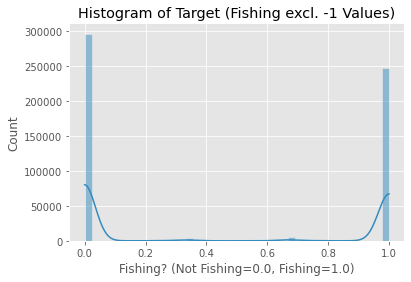

In [36]:
# drop -1 labels and produce histogram to show distribution of target
temp_boats = boats_df.loc[boats_df['is_fishing'] != -1]
ax = sns.histplot(data=temp_boats['is_fishing'], bins='auto', kde=True)
plt.title('Histogram of Target (Fishing excl. -1 Values)')
plt.xlabel('Fishing? (Not Fishing=0.0, Fishing=1.0)')

Distribution of our target labels range from 0 to 1, when removing labels lacking any information (`-1`).  The majority of entries fall as either 0 or 1, and we know from the above descriptions, that values between 0 and 1 indicate the average score if scored by multiple people.  For this reason, any value between 0 and 1 has some sort of uncertainty from a labeling perspective, and these values will be removed in the data preparation stage.  With more than 250,000 `1` labels remaining and more than 295,000 `0` labels remaining, we should have more than enough remaining data after removing values between 0 and 1.  

In [37]:
# remove labels that are not 1 or 0
boats_df = boats_df.loc[(boats_df['is_fishing'] == 0) | 
                        (boats_df['is_fishing'] == 1)]

#### AIS Predictors

In [38]:
# separate out predictors
ais_predictors = boats_df.drop('is_fishing', axis=1)

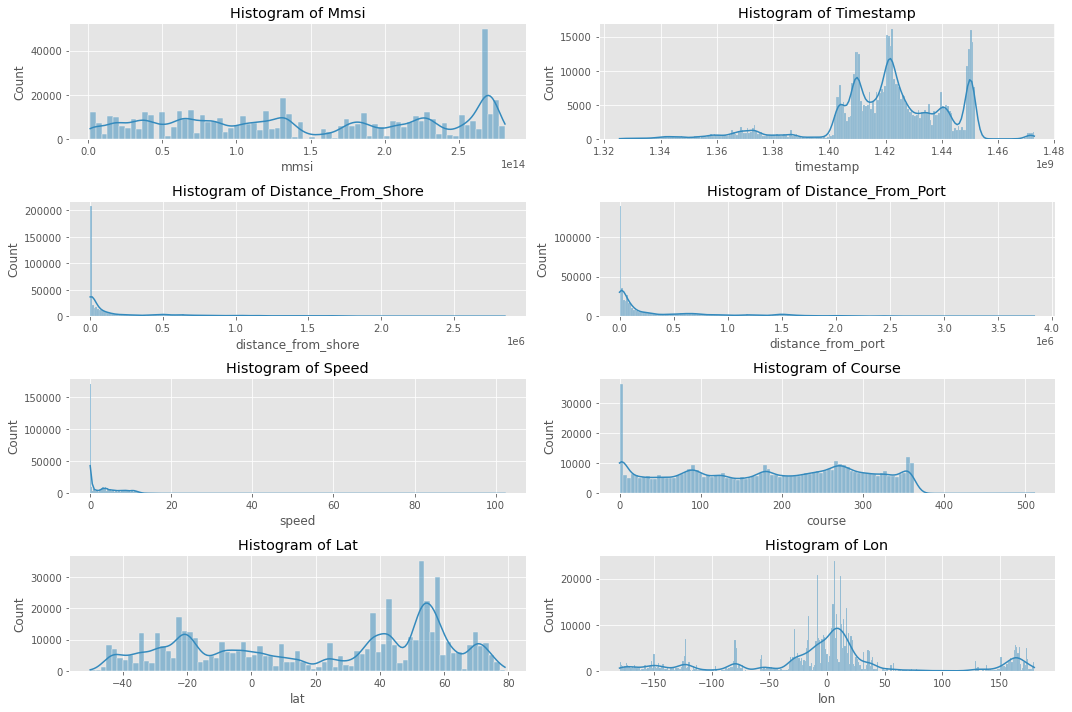

In [39]:
# plot distributions of predictors
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
for ax, feat in zip(axes.flatten(), ais_predictors.columns):
    sns.histplot(data=ais_predictors[feat], kde=True, bins='auto', ax=ax)
    ax.set_title(f'Histogram of {feat.title()}')
    ax.set_xlabel(feat)
plt.tight_layout()
plt.show()

Looking at the distributions of our predictor columns, we see some of the following observations:
- `mmsi`: some ships are definitely more present, but overall not too concentrated on any one ship identifier
- `timestamp`: we see that there are more entries with later timestamps, signaling more of our data is coming from later timestamps and dates
- `distance_from_shore`: difficult to see from this view, may include some outliers or a large range of values
- `distance_from_port`: difficult to see from this view, may include some outliers or a large range of values
- `speeed`: difficult to see from this view, may include some outliers or a large range of values
- `course`: a large number of entries with a course of 0.  Frequency spikes just under 100, 200, 300, and 400
- `lat`: majority of values seem centered around -25 or 50
- `lon`: majority of values seem centered around 0 with a cluster of values just above 150 as well. 

In [40]:
# convert min and max timestamp to datetime to understand range of data better
max_unix = boats_df['timestamp'].max()
min_unix = boats_df['timestamp'].min()
converted_max_ts = datetime.utcfromtimestamp(max_unix).strftime('%Y-%m-%d %H:%M:%S')
converted_min_ts = datetime.utcfromtimestamp(min_unix).strftime('%Y-%m-%d %H:%M:%S')

print(f'timestamps range from {converted_min_ts} to {converted_max_ts}')

timestamps range from 2012-01-01 09:21:55 to 2016-09-03 08:07:53


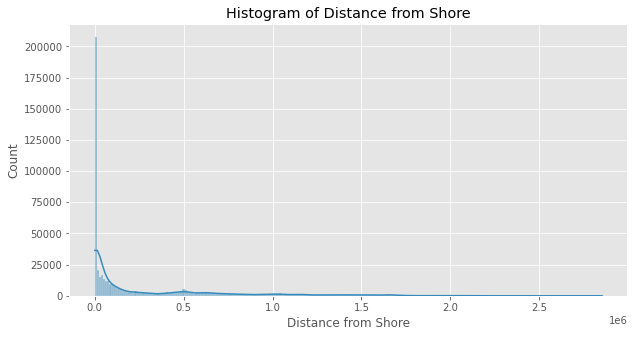

In [41]:
# replot distance from shore
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=boats_df['distance_from_shore'], bins='auto', kde=True)
plt.title('Histogram of Distance from Shore')
plt.xlabel('Distance from Shore')
plt.show()

Large number of values with 0 distance from shore, signaling the boat is docked or at shore. There is a right skew to the rest of the values. 

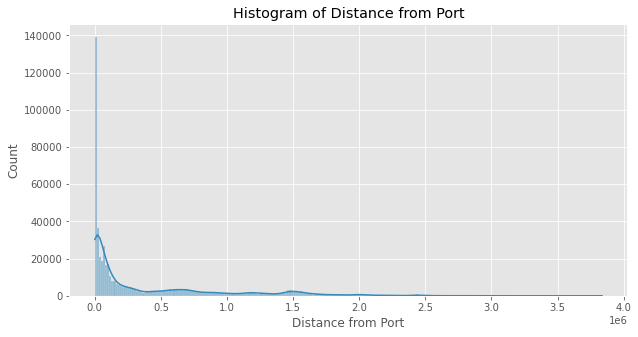

In [42]:
# replot distance from port
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=boats_df['distance_from_port'], bins='auto', kde=True)
plt.title('Histogram of Distance from Port')
plt.xlabel('Distance from Port')
plt.show()

Similar to distance_from_shore, there are a large number of values with 0 distance to port, signaling the boat is at port.  There is a right skew to the rest of the values. 

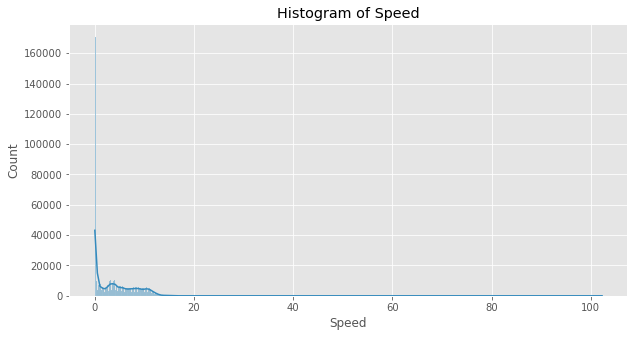

In [43]:
# replot speed
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=boats_df['speed'], bins='auto', kde=True)
plt.title('Histogram of Speed')
plt.xlabel('Speed')
plt.show()

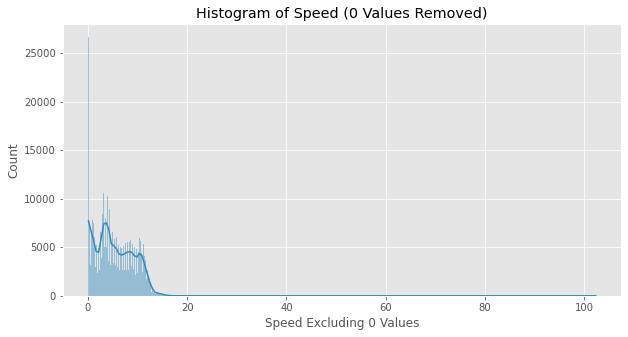

In [44]:
# replot with 0 values removed
temp_boats = boats_df.loc[boats_df['speed'] > 0]
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=temp_boats['speed'], bins='auto', kde=True)
plt.title('Histogram of Speed (0 Values Removed)')
plt.xlabel('Speed Excluding 0 Values')
plt.show()

Removing zero values, we can see the majority of speed values fall between 0 and 20. There are some larger speed values that fall outside of this range.

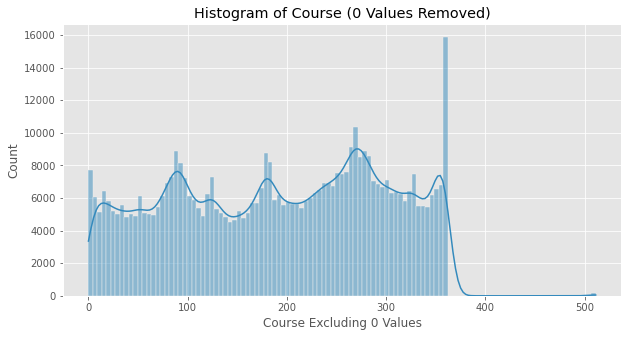

In [45]:
# look at course values
temp_boats = boats_df.loc[boats_df['course'] > 0]
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=temp_boats['course'], bins='auto', kde=True)
plt.title('Histogram of Course (0 Values Removed)')
plt.xlabel('Course Excluding 0 Values')
plt.show()

The concentration of values just under 100, 200, 300, and 400 make sense when considering course data, or headings.   A heading of 0, corresponds to true north, as does a heading or course value of 360.  A heading of 90 corresponds to true east, 180 to true south,and 270 to true west.  These values correspond to the bumps we see in the histogram above. 

In [46]:
# vessel_type
vessel_crosstab = pd.crosstab(boats_df['vessel_type'], 
                              boats_df['is_fishing'], 
                              normalize='index')

vessel_crosstab

is_fishing,0.0,1.0
vessel_type,,
drifting_longline,0.365459,0.634541
fixed_gear,0.736374,0.263626
pole_and_line,0.792218,0.207782
purse_seine,0.878098,0.121902
trawler,0.645971,0.354029
troller,0.615405,0.384595
unknown,0.603443,0.396557


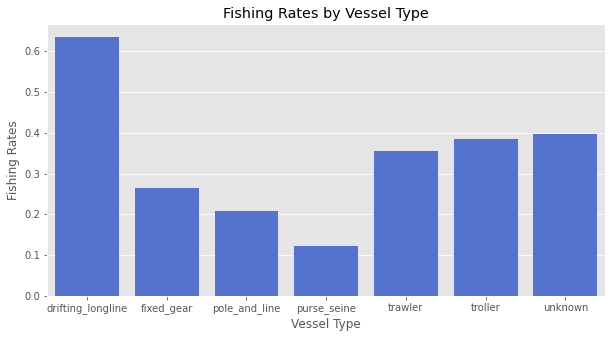

In [47]:
# plot vessel crosstab
fishing_vessels = vessel_crosstab[1.0]
fishing_vessels = fishing_vessels.reset_index()
fishing_vessels.columns = ['vessel', 'is_fishing']
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=fishing_vessels['vessel'], y=fishing_vessels['is_fishing'], color='royalblue')
plt.title('Fishing Rates by Vessel Type')
plt.xlabel('Vessel Type')
plt.ylabel('Fishing Rates')
plt.show()

We can see that just over 60% of all drifting_longline timestamps are marked as fishing, which is larger than the other vessels.  Fishing rate is also high among trawler, troller, and unknown. 

In [48]:
# boxplots and other plots to show difference between is_fishing labels

In [49]:
# separate out number columns
num_cols = ['timestamp', 'distance_from_shore', 'distance_from_port',
            'speed', 'course', 'lat', 'lon']

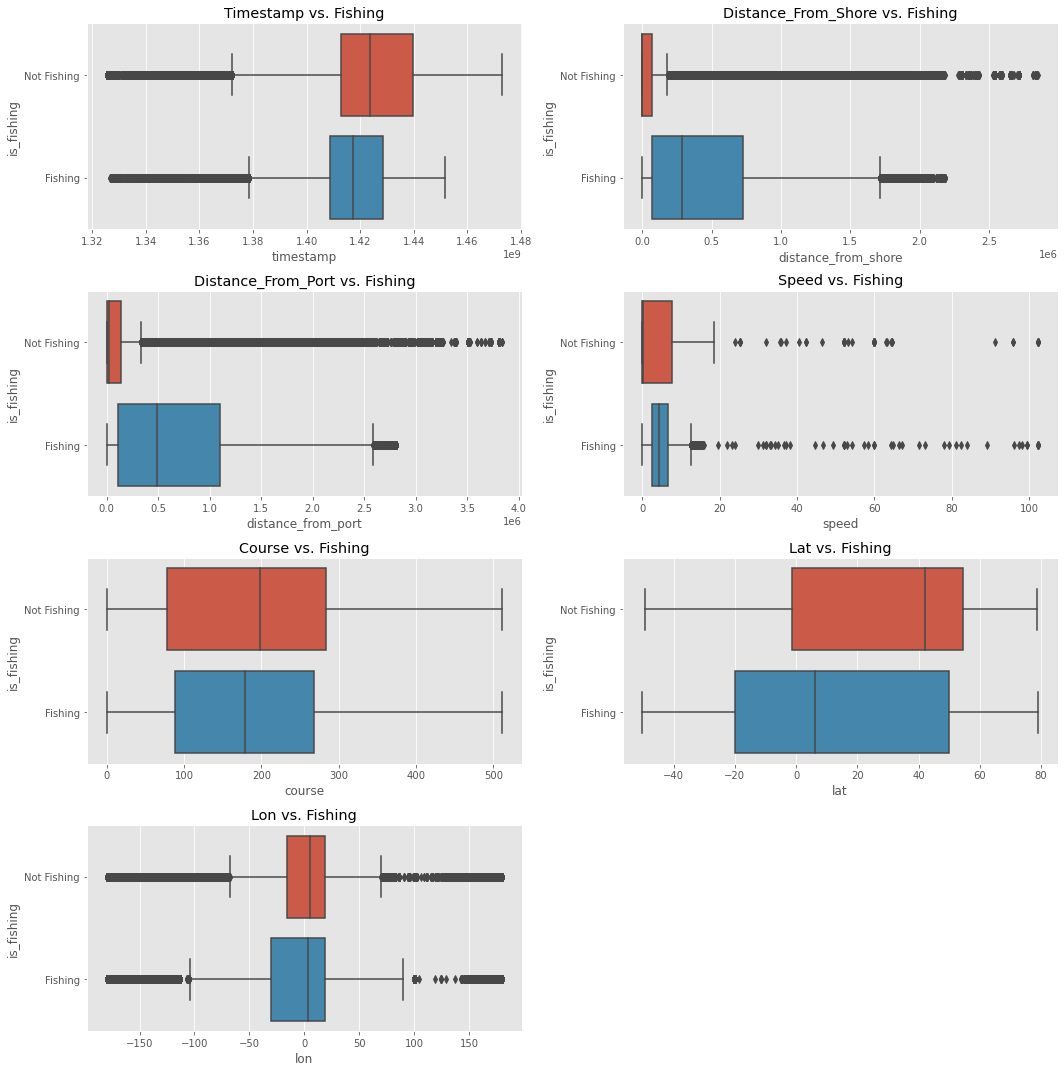

In [50]:
# plot boxplots per label
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for ax, feat in zip(axes.flatten(), num_cols):
    sns.boxplot(x=feat, y=boats_df['is_fishing'].astype('category'), data=boats_df, ax=ax)
    ax.set_title(f'{feat.title()} vs. Fishing')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Not Fishing', 'Fishing'])
    plt.tight_layout()
    
# drop empty subplots from figure
fig.delaxes(axes[3, 1])
plt.show()

Looking at the boxplots, we can see there are some clear differences between `is_fishing`=1 and `is_fishing`=0. 
- `timestamp`: median timestamp for boats that are fishing is slightly lower than the median timestamp for boats that are not fishing.
- `distance_from_shore`: The median distance from shore for boats that are fishing is greater than those that are not fishing, which is not necessarily that surprising. 
- `distance_from_port`: Similar to distance from shore, those boats labeled as fishing have greater median distances from port.
- `speed`: boats labeled as fishing seem to have higher median speeds than those labeled as not fishing
- `course`: slight median difference in course, IQR range is slightly smaller for those labeled as fishing
- `lat`: lower median lats for vessels labeled as fishing compared to those labeled as not fishing
- `lon`: differing from latitudes, median longitudes are in line

## NOAA Ocean Station Data (OSD)
Ocean station data was sourced from the following url: `https://www.ncei.noaa.gov/access/world-ocean-database-select/dbsearch.html`.

Using the WODselect retrieval system enables a user to search World Ocean Database and new data using user-specified criteria. I specifically retreived OSD data using all available coordinates, and limited my timestamps to match the range present in the Global Fishing Watch AIS datasets. 

The World Ocean Database is encoded per the following documentation: `https://www.ncei.noaa.gov/data/oceans/woa/WOD/DOC/wodreadme.pdf`

As a result, downloaded files are returned in a native `.OSD` format.  To handle reading and importing of `.OSD` data, I made use of the `wodpy` package.  More information regarding `wodpy` can be found: `https://github.com/IQuOD/wodpy`.  

In [51]:
# import necessary libraries
from wodpy import wod
fid = open('data/ocldb1642977297.29281.OSD')
profile = wod.WodProfile(fid) # test reading of .OSD file
profile

In [52]:
# convert profile to dataframe
ods_profile = profile.df()

/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/wodpy/wod.py:792: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.meta = meta


In [53]:
# profile information
ods_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   z           93 non-null     float64
 1   z_level_qc  93 non-null     int64  
 2   z_unc       0 non-null      float64
 3   t           91 non-null     float64
 4   t_level_qc  91 non-null     float64
 5   t_unc       0 non-null      float64
 6   s           91 non-null     float64
 7   s_level_qc  91 non-null     float64
 8   s_unc       0 non-null      float64
 9   oxygen      91 non-null     float64
 10  phosphate   91 non-null     float64
 11  silicate    91 non-null     float64
 12  pH          91 non-null     float64
 13  p           0 non-null      float64
dtypes: float64(13), int64(1)
memory usage: 10.3 KB


After successful loading of one OSD profile, we have access to the following information:
* `z`: level depths in meters
* `z_level_qc`: level depth qc flags (0 == all good)
* `z_unc`: depth uncertainty
* `t`: level temperature in Celcius
* `t_level_qc`: level temperature qc flags (0 == all good)
* `t_unc`: temperature uncertainty
* `s`: level salinities
* `s_level_qc`: level salinity qc flags (0 == all good)
* `s_unc`: salinity uncertainty
* `oxygen`: oxygen content (mL / L)
* `phosphate`: phosphate content (uM / L)
* `silicate`: silicate content (uM / L)
* `pH`: pH levels
* `p`: pressure (decibar)

In [54]:
# each profile also has additional information stored in the .meta attribute
ods_profile.meta

{'latitude': 2.2528,
 'latitude_unc': None,
 'longitude': 146.783,
 'longitude_unc': None,
 'uid': 16621322,
 'n_levels': 93,
 'year': 2012,
 'month': 1,
 'day': 1,
 'time': 0.667,
 'cruise': 39079,
 'probe_type': 7.0,
 'originator_flag_type': 1.0,
 'PIs': None,
 'originator_station': None,
 'originator_cruise': '49NZ20111220',
 't_metadata': [{'value': 103.0, 'code': 3, 'iMeta': 0},
  {'value': 4.0, 'code': 5, 'iMeta': 0}],
 's_metadata': [{'value': 202.0, 'code': 3, 'iMeta': 0}]}

Looking at the metadata for our first ODS profile, we can see there is a bunch of additional relevant information here, particularly the latitude and longitude information, which we can ultimately use to merge with our AIS data. 

In [55]:
# reset ODS reader
ods_file = open('data/ocldb1642977297.29281.OSD')
ods_profile = wod.WodProfile(fid)

In [56]:
# use while loop to pull in all profiles
# WARNING - this will take several minutes to run
ods_df = pd.DataFrame()
n = 1 # used to track loop progress

while ods_profile.is_last_profile_in_file(fid) == False:
    
    # get df and meta information
    profile_df = ods_profile.df()
    profile_meta = profile_df.meta
    
    # add columns
    profile_df['lat'] = profile_meta['latitude']
    profile_df['lon'] = profile_meta['longitude']
    profile_df['year'] = profile_meta['year']
    profile_df['month'] = profile_meta['month']
    profile_df['day'] = profile_meta['day']
    profile_df['time'] = profile_meta['time']
    
    # concat df
    ods_df = pd.concat([profile_df, ods_df], axis=0)
    
    # update to next ods_profile
    ods_profile = wod.WodProfile(fid)

In [57]:
# display first 5 rows
ods_df.head()

,z,z_level_qc,z_unc,t,t_level_qc,t_unc,s,s_level_qc,s_unc,oxygen,phosphate,silicate,pH,p,lat,lon,year,month,day,time
0,0.0,0,NaN,27.8156,0.0,NaN,32.7162,0.0,NaN,201.1,0.142,0.5,8.0892,NaN,9.4996,-110.0001,2016,12,1,16.13
1,5.0,0,NaN,27.7961,0.0,NaN,32.7229,0.0,NaN,201.0,0.145,0.5,8.0887,NaN,9.4996,-110.0001,2016,12,1,16.13
2,10.0,0,NaN,27.7499,0.0,NaN,32.7388,0.0,NaN,200.7,0.153,0.6,8.0876,NaN,9.4996,-110.0001,2016,12,1,16.13
3,15.0,0,NaN,27.7037,0.0,NaN,32.7548,0.0,NaN,200.4,0.160,0.6,8.0865,NaN,9.4996,-110.0001,2016,12,1,16.13
4,20.0,0,NaN,27.6576,0.0,NaN,32.7707,0.0,NaN,200.1,0.168,0.6,8.0854,NaN,9.4996,-110.0001,2016,12,1,16.13


In [58]:
# display info
ods_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554826 entries, 0 to 0
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   z           554826 non-null  float64
 1   z_level_qc  554826 non-null  int64  
 2   z_unc       0 non-null       float64
 3   t           466323 non-null  float64
 4   t_level_qc  466323 non-null  float64
 5   t_unc       0 non-null       float64
 6   s           422020 non-null  float64
 7   s_level_qc  422020 non-null  float64
 8   s_unc       0 non-null       float64
 9   oxygen      406869 non-null  float64
 10  phosphate   383805 non-null  float64
 11  silicate    377030 non-null  float64
 12  pH          182788 non-null  float64
 13  p           0 non-null       float64
 14  lat         554826 non-null  float64
 15  lon         554826 non-null  float64
 16  year        554826 non-null  int64  
 17  month       554826 non-null  int64  
 18  day         554826 non-null  int64  
 19  time   

In [59]:
# summary stats of cont. columns
ods_df.describe()

,z,z_level_qc,z_unc,t,t_level_qc,t_unc,s,s_level_qc,s_unc,oxygen,phosphate,silicate,pH,p,lat,lon,year,month,day,time
count,554826.000000,554826.0,0.0,466323.000000,466323.000000,0.0,422020.000000,422020.000000,0.0,406869.000000,383805.000000,377030.000000,182788.000000,0.0,554826.000000,554826.000000,554826.000000,554826.000000,554826.000000,546470.000000
mean,664.650025,0.0,NaN,8.674232,0.084025,NaN,28.492345,0.291901,NaN,212.464138,1.331758,42.866184,7.791573,NaN,26.545191,-4.834392,2013.653338,5.940306,15.295453,11.547927
std,1109.273445,0.0,NaN,7.180532,0.753279,NaN,10.973218,1.504564,NaN,95.479393,1.037013,50.018932,0.284217,NaN,36.941103,98.207203,1.409427,3.178841,8.644863,6.594706
min,0.000000,0.0,NaN,-2.949000,0.000000,NaN,0.010000,0.000000,NaN,0.000000,0.000000,0.000000,6.000000,NaN,-70.574200,-179.893400,2012.000000,1.000000,1.000000,0.000000
25%,30.000000,0.0,NaN,2.898000,0.000000,NaN,29.900900,0.000000,NaN,152.000000,0.370000,3.810000,7.584600,NaN,9.482700,-68.376300,2012.000000,4.000000,8.000000,6.420000
50%,90.000000,0.0,NaN,6.878100,0.000000,NaN,34.397700,0.000000,NaN,217.000000,1.090000,17.000000,7.730900,NaN,33.781700,0.394500,2013.000000,6.000000,15.000000,11.200000
75%,800.000000,0.0,NaN,12.939000,0.000000,NaN,34.858000,0.000000,NaN,271.000000,2.280000,72.200000,8.000000,NaN,56.000000,25.617000,2015.000000,8.000000,22.000000,16.870000
max,6100.000000,0.0,NaN,31.227400,9.000000,NaN,38.497800,9.000000,NaN,523.000000,12.195000,243.900000,9.200000,NaN,89.990900,179.997200,2016.000000,12.000000,31.000000,23.980000


We can see the ocean station data we've read using `wodpy` takes up 88.9 MB of space.  The dataset itself contains additional features that will ultimately be merged with our AIS data to predict `is_fishing`.  

There are a total of 20 columns in the dataset, and a total of 554,826 entries. All columns are of type float, with the exception of the `z_level_qc`, `year`, `month`, and `day` features, which are of type int.

### Distribution of ODS Data

In [60]:
# remove unecessary columns and produce histogram
# drop columns
clean_ods_df = ods_df.drop(['z_level_qc', 'z_unc', 't_level_qc', 't_unc', 
                            's_level_qc', 's_unc', 'p'], axis=1)

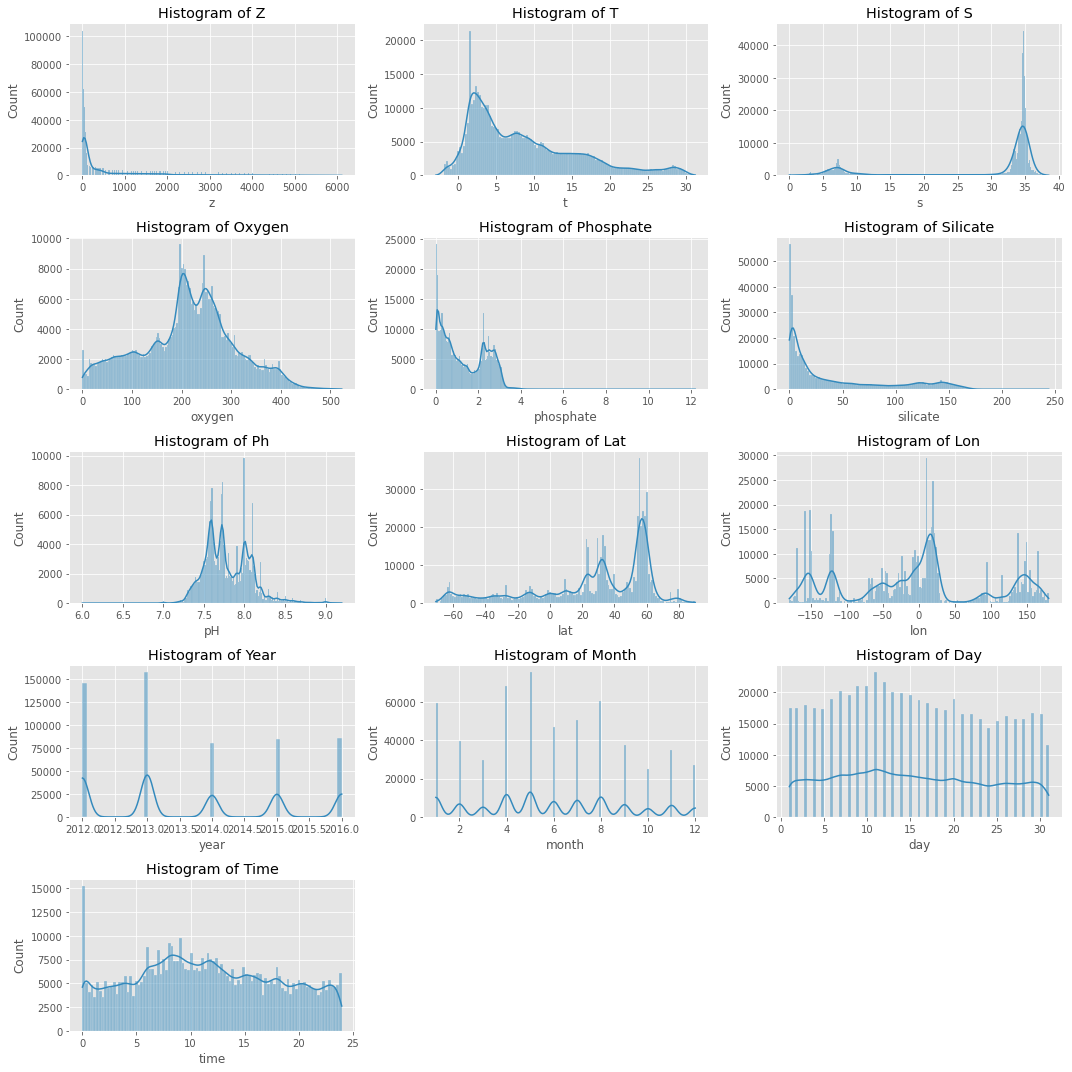

In [61]:
# produce histograms of ODS features to evaluate distributions
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
for ax, feat in zip(axes.flatten(), clean_ods_df.columns):
    sns.histplot(data=clean_ods_df[feat], kde=True, bins='auto', ax=ax)
    ax.set_title(f'Histogram of {feat.title()}') # hist titles
    ax.set_xlabel(feat) # x-axis labels
    
# remove empty subplots
for i in range(1, 3):
    fig.delaxes(axes[4, i])

# tight layout
plt.tight_layout()
plt.show()

Looking at the above distributions:
- `z`: we can see there is a cluster of observations at 0 and around 0, and then some right skew
- `t`: see a cluster of data around 0, with some right skew.  Also some negative values present.
- `s`: seems to be bimodal with values right below 10 and another cluster between 30 and 40
- `oxygen`: seems somewhat normally distributed with the majority of values falling between 150 and 300
- `phosphate`: seems to be a lot of 0 values, and then another cluster of values around 2.5
- `silicate`: majority of values near 0, with some right skew. 
- `pH`: seems somewhat normally distributed with the majority of values falling between 7 and 8.5
- `lat`: majority of values near lat value of 50
- `lon`: majority of values seem to be near lon value of 0 in addition to clusters below -100 and above 100
- `year`: years match AIS dataset, with the majority of data falling in 2012 and 2013.
- `month`, `day`, and `time`: seem distributed as we would likely expect. 

## Merged Datasets

The two datasets will now be merged using latitude and longitude as matching key values. Given the amount of data, a ball tree is used to identify the nearest lat, long pairs in the ods dataset and match to the AIS data. Tried to compute haversine distance for each point, and then map in proper values, but run time was too long. 

In [62]:
from math import radians

In [63]:
# convert coords to radians to compute haversine distance (good for lat, lon pairs)
boats_df['lat_radian'] = boats_df['lat'].apply(lambda x: radians(x))
boats_df['lon_radian'] = boats_df['lon'].apply(lambda x: radians(x))
clean_ods_df['lat_radian'] = clean_ods_df['lat'].apply(lambda x: radians(x))
clean_ods_df['lon_radian'] = clean_ods_df['lon'].apply(lambda x: radians(x))

Found some guidance here for efficiently mapping to lat, long neighbors: https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd929b

In [64]:
from sklearn.neighbors import BallTree

In [65]:
# create ball tree to find min distances, find the closest neighbor
ball_tree = BallTree(clean_ods_df[['lat_radian', 'lon_radian']].values, metric='haversine')
dists, idxs = ball_tree.query(boats_df[['lat_radian', 'lon_radian']].values, k=3)

In [66]:
def haversine_to_km(haversine_distance):
    """
    Returns haversine distance in kilometers
    """
    return haversine_distance * 6371000/1000

In [67]:
median_dist = np.median(dists)
median_dist_km = haversine_to_km(median_dist)
median_dist_km

368.91234399254154

The median distance from ocean station data to our AIS data is ~369 kilometers.  While this may seem far, this may not account for large distances between ocean stations and vessels at port or on shore.  In the future, we may be able to spend the computation time necessary to pull in more exact data, but given runtime limitations, we will keep this method.

In [68]:
idxs[:4]

array([[204335, 204334, 204368],
       [201178, 201176, 201177],
       [201178, 201176, 201177],
       [204335, 204334, 204368]])

In [69]:
clean_ods_df.iloc[idxs[1][0]]['z']

25.0

In [70]:
clean_ods_df.iloc[idxs[1][1]]['z']

15.0

In [71]:
clean_ods_df.iloc[idxs[1][2]]['z']

20.0

In [72]:
# go thru each set of neighbors returned, and calc the median value for each new column
# WARNING - will take several minutes to run
depths = []
temps = []
sals = []
oxygens = []
pHs = []
phosphates = []
silicates = []

for index_list in idxs:
    # pull corresponding row to index
    ods_0 = clean_ods_df.iloc[index_list[0]]
    ods_1 = clean_ods_df.iloc[index_list[1]]
    ods_2 = clean_ods_df.iloc[index_list[2]]
    
    # calc median ods vals
    median_depth = np.median([ods_0['z'], ods_1['z'], ods_2['z']])
    median_temp = np.median([ods_0['t'], ods_1['t'], ods_2['t']])
    median_sal = np.median([ods_0['s'], ods_1['s'], ods_2['s']])
    median_oxygen = np.median([ods_0['oxygen'], ods_1['oxygen'], ods_2['oxygen']])
    median_pH = np.median([ods_0['pH'], ods_1['pH'], ods_2['pH']])
    median_phosphate = np.median([ods_0['phosphate'], ods_1['phosphate'], ods_2['phosphate']])
    median_silicate = np.median([ods_0['silicate'], ods_1['silicate'], ods_2['silicate']])
    
    # append median vals
    depths.append(median_depth)
    temps.append(median_temp)
    sals.append(median_sal)
    oxygens.append(median_oxygen)
    pHs.append(median_pH)
    phosphates.append(median_phosphate)
    silicates.append(median_silicate)

In [73]:
# check that the lenght matches length of boats_df
len(boats_df) == len(depths)

True

In [74]:
# create new columns
boats_df['depth'] = depths
boats_df['temp'] = temps
boats_df['salinity'] = sals
boats_df['oxygen'] = oxygens
boats_df['pH'] = pHs
boats_df['phosphate'] = phosphates
boats_df['silicate'] = silicates

In [75]:
# print new info of df
boats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543477 entries, 330 to 6806721
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   mmsi                 543477 non-null  float64
 1   timestamp            543477 non-null  float64
 2   distance_from_shore  543477 non-null  float64
 3   distance_from_port   543477 non-null  float64
 4   speed                543475 non-null  float64
 5   course               543475 non-null  float64
 6   lat                  543477 non-null  float64
 7   lon                  543477 non-null  float64
 8   is_fishing           543477 non-null  float64
 9   source               543477 non-null  object 
 10  vessel_type          543477 non-null  object 
 11  lat_radian           543477 non-null  float64
 12  lon_radian           543477 non-null  float64
 13  depth                543477 non-null  float64
 14  temp                 379267 non-null  float64
 15  salinity      

We can see that the merging of our datasets was successful, despite some values missing out of the temp, salinity, oxygen, pH, phosphate, and silicate columns.

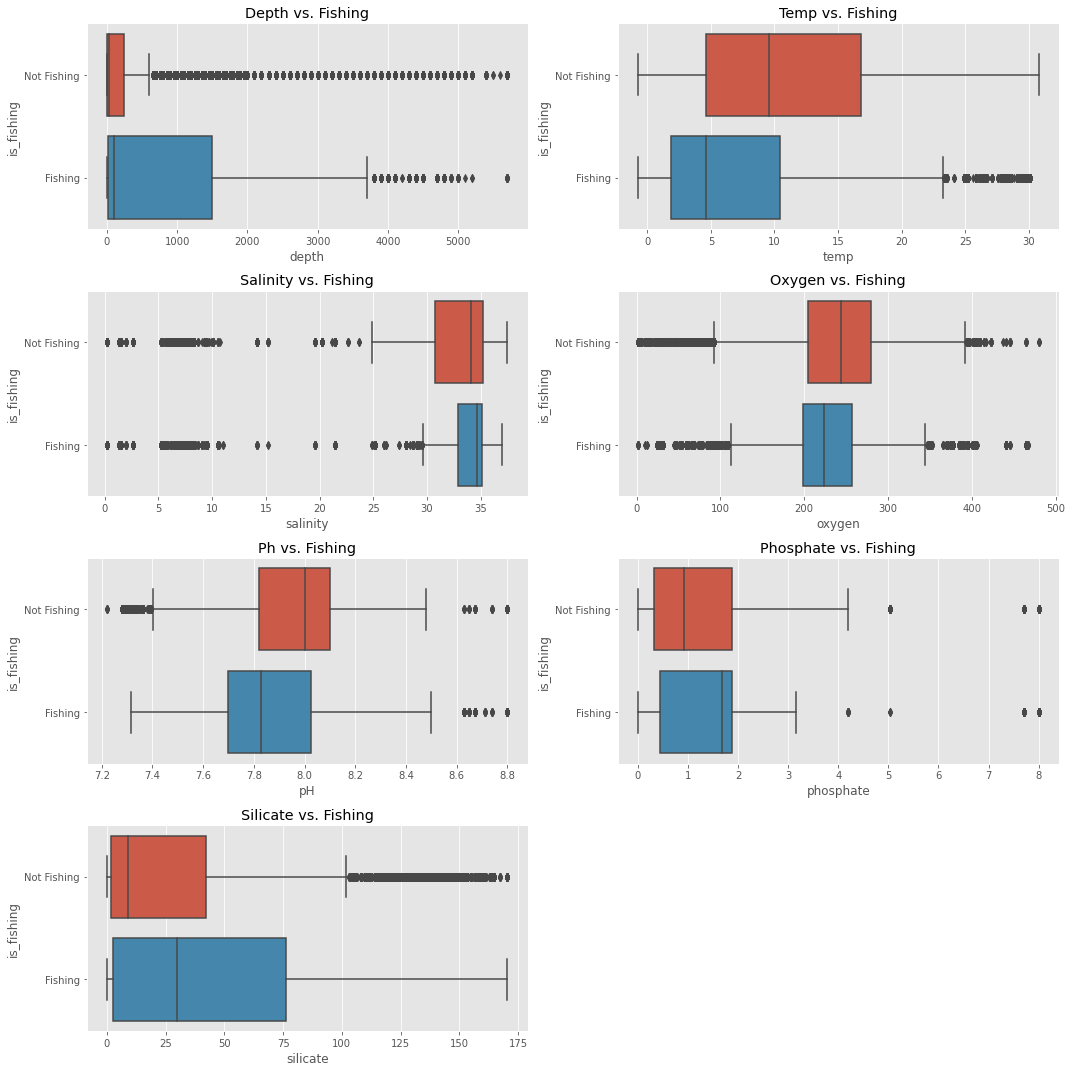

In [76]:
ods_cols = ['depth', 'temp', 'salinity', 'oxygen', 'pH', 'phosphate', 'silicate']

# plot boxplots per label
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for ax, feat in zip(axes.flatten(), ods_cols):
    sns.boxplot(x=feat, y=boats_df['is_fishing'].astype('category'), data=boats_df, ax=ax)
    ax.set_title(f'{feat.title()} vs. Fishing')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Not Fishing', 'Fishing'])

# drop empty subplots
fig.delaxes(axes[3, 1])
            
# tight layout
plt.tight_layout()
plt.show()

The biggest differences between boats that are fishing and not fishing can be seen in `temp`, `pH`, and `silicate`

I leveraged the following [post](https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6) to plot data points based on latitude and longitude coordinates.

The below graph will plot all datapoints where Fishing=1 and where Fishing=0.  This should help visualize where these vessels are in the world, and potentially geographical differences between vessels that are actively fishing and those that are not.

In [77]:
# map of fishing data
fishing = boats_df.loc[boats_df['is_fishing'] == 1]
not_fishing = boats_df.loc[boats_df['is_fishing'] == 0]

fishing_geo = [Point(xy) for xy in zip(fishing['lon'], fishing['lat'])]
fishing_gdf = GeoDataFrame(fishing, geometry=fishing_geo)

non_geo = [Point(xy) for xy in zip(not_fishing['lon'], not_fishing['lat'])]
non_gdf = GeoDataFrame(not_fishing, geometry=non_geo)

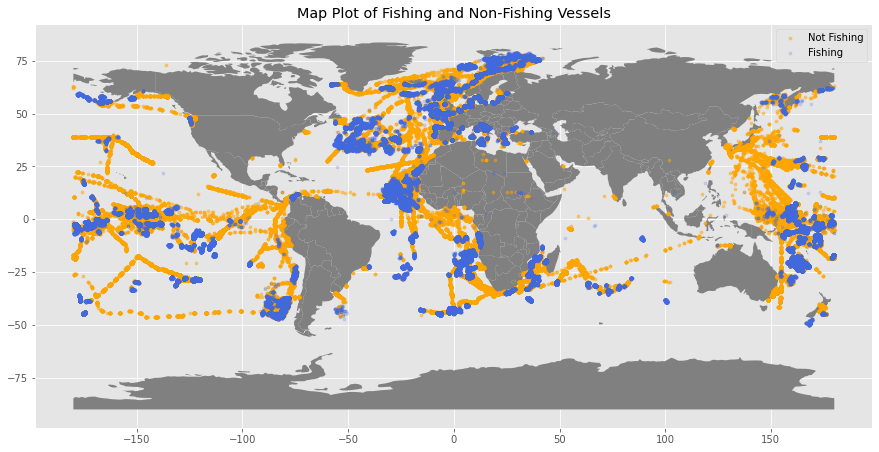

In [78]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 10), color='grey')
non_gdf.plot(ax=ax, marker='o', color='orange', markersize=10, alpha=0.5);
fishing_gdf.plot(ax=ax, marker='o', color='royalblue', markersize=10, alpha=0.2);
plt.legend(['Not Fishing', 'Fishing'])
plt.title('Map Plot of Fishing and Non-Fishing Vessels')
plt.show()

Looking at the above map plot, we see that there are lat/lon hot zones that represent `is_fishing`=1, as represented by the green markers. Red markers indicate vessels that are not fishing. 

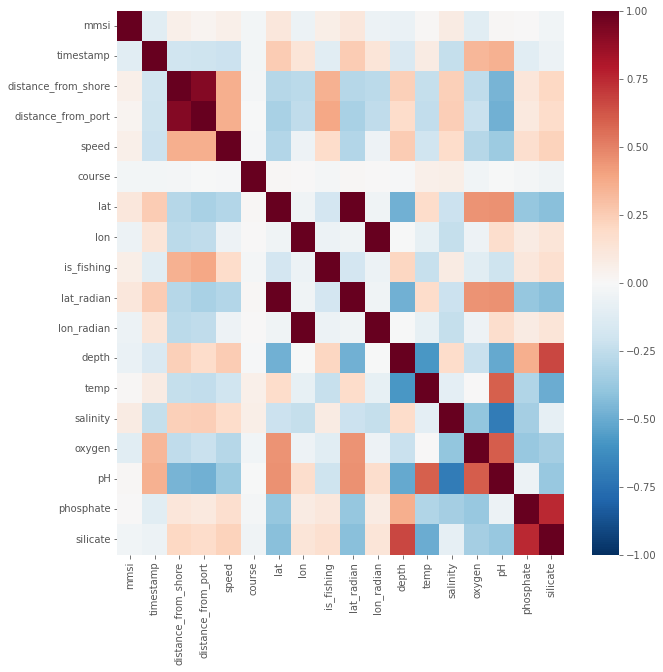

In [79]:
# plot heatmap of correlations to see if any correlation amongst predictors
corr = boats_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu_r', annot=False, vmax=1, vmin=-1)
plt.show()

From the above correlation heatmap, we can confirm that lat_radian and lon_radian are perfectly correlated with non-radian matches, which makes sense.  Additionally, we see the following relationships:
- `depth` is very positively correlated with `silicate`
- `phosphate` is very positively correlated with `silicate`
- `distance_from_port` is very positively correlated with `distance_from_shore`
- `pH` is fairly negatively correlated with `salinity`, as well as `distance_from_shore` and `distance_from_port`
- `depth` is negatively correlated with `temp`

Additionally, we can look at the `is_fishing` column to see what is potentially correlated with our labels -- we see the strongest relationships between `is_fishing` and `distance_from_shore` and `distance_from_port`.

This information will be helpful as predictors are identified in our models.  Based on the information above, it will make sense to drop perfectly correlated predictors.

# 3. Data Preparation

With a solid understanding of our datasets, and the features available to us, can move forward with processing and preparing datasets for modeling.

- Detecting and dealing with missing values
- Data type conversions
- Checking for and removing multicollinearity 
- Normalizing numeric data
- Converting categorical data to numeric format thru one-hot encoding

In [80]:
# set seed for reproducibility
SEED = 23

In [81]:
# pull in raw version of merged dataset
raw_df = boats_df.copy()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543477 entries, 330 to 6806721
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   mmsi                 543477 non-null  float64
 1   timestamp            543477 non-null  float64
 2   distance_from_shore  543477 non-null  float64
 3   distance_from_port   543477 non-null  float64
 4   speed                543475 non-null  float64
 5   course               543475 non-null  float64
 6   lat                  543477 non-null  float64
 7   lon                  543477 non-null  float64
 8   is_fishing           543477 non-null  float64
 9   source               543477 non-null  object 
 10  vessel_type          543477 non-null  object 
 11  lat_radian           543477 non-null  float64
 12  lon_radian           543477 non-null  float64
 13  depth                543477 non-null  float64
 14  temp                 379267 non-null  float64
 15  salinity      

In [82]:
# check for missing values
raw_df.isna().sum()

mmsi                        0
timestamp                   0
distance_from_shore         0
distance_from_port          0
speed                       2
course                      2
lat                         0
lon                         0
is_fishing                  0
source                      0
vessel_type                 0
lat_radian                  0
lon_radian                  0
depth                       0
temp                   164210
salinity               237319
oxygen                 235792
pH                     371540
phosphate              195898
silicate               189096
dtype: int64

The majority of missing values come from our mapped ODS columns, which is not surprising as some of those values were NaNs, or missing values. Given the majority of data these missing values represent, dropping all of them would remove helpful data from our dataset.  Instead, all missing values will be filled with its column median to help preserve some of the data. 

In [83]:
# handle missing values with column medians
raw_df['temp'] = raw_df['temp'].fillna(raw_df['temp'].median())
raw_df['salinity'] = raw_df['salinity'].fillna(raw_df['salinity'].median())
raw_df['oxygen'] = raw_df['oxygen'].fillna(raw_df['oxygen'].median())
raw_df['pH'] = raw_df['pH'].fillna(raw_df['pH'].median())
raw_df['phosphate'] = raw_df['phosphate'].fillna(raw_df['phosphate'].median())
raw_df['silicate'] = raw_df['silicate'].fillna(raw_df['silicate'].median())

In [84]:
raw_df.isna().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  2
course                 2
lat                    0
lon                    0
is_fishing             0
source                 0
vessel_type            0
lat_radian             0
lon_radian             0
depth                  0
temp                   0
salinity               0
oxygen                 0
pH                     0
phosphate              0
silicate               0
dtype: int64

In [85]:
# drop remaining missing values out of speed and course column
raw_df = raw_df.dropna()
raw_df.isna().sum()

mmsi                   0
timestamp              0
distance_from_shore    0
distance_from_port     0
speed                  0
course                 0
lat                    0
lon                    0
is_fishing             0
source                 0
vessel_type            0
lat_radian             0
lon_radian             0
depth                  0
temp                   0
salinity               0
oxygen                 0
pH                     0
phosphate              0
silicate               0
dtype: int64

In [86]:
# check for duplicates
raw_df.duplicated().any()

False

Missing values and duplicates have been handled. Move on to addressing column types, one hot encoding, etc. 

In [87]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543475 entries, 330 to 6806721
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   mmsi                 543475 non-null  float64
 1   timestamp            543475 non-null  float64
 2   distance_from_shore  543475 non-null  float64
 3   distance_from_port   543475 non-null  float64
 4   speed                543475 non-null  float64
 5   course               543475 non-null  float64
 6   lat                  543475 non-null  float64
 7   lon                  543475 non-null  float64
 8   is_fishing           543475 non-null  float64
 9   source               543475 non-null  object 
 10  vessel_type          543475 non-null  object 
 11  lat_radian           543475 non-null  float64
 12  lon_radian           543475 non-null  float64
 13  depth                543475 non-null  float64
 14  temp                 543475 non-null  float64
 15  salinity      

In [88]:
# drop unnecessary columns
clean_df = raw_df.drop(['mmsi', 'source', 'timestamp'], axis=1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543475 entries, 330 to 6806721
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   distance_from_shore  543475 non-null  float64
 1   distance_from_port   543475 non-null  float64
 2   speed                543475 non-null  float64
 3   course               543475 non-null  float64
 4   lat                  543475 non-null  float64
 5   lon                  543475 non-null  float64
 6   is_fishing           543475 non-null  float64
 7   vessel_type          543475 non-null  object 
 8   lat_radian           543475 non-null  float64
 9   lon_radian           543475 non-null  float64
 10  depth                543475 non-null  float64
 11  temp                 543475 non-null  float64
 12  salinity             543475 non-null  float64
 13  oxygen               543475 non-null  float64
 14  pH                   543475 non-null  float64
 15  phosphate     

In [89]:
# drop columns that are perfectly correlated with other predictors
clean_df = clean_df.drop(['lat_radian', 
                          'lon_radian'], axis=1)

In [90]:
# reset index
clean_df = clean_df.reset_index(drop=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543475 entries, 0 to 543474
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   distance_from_shore  543475 non-null  float64
 1   distance_from_port   543475 non-null  float64
 2   speed                543475 non-null  float64
 3   course               543475 non-null  float64
 4   lat                  543475 non-null  float64
 5   lon                  543475 non-null  float64
 6   is_fishing           543475 non-null  float64
 7   vessel_type          543475 non-null  object 
 8   depth                543475 non-null  float64
 9   temp                 543475 non-null  float64
 10  salinity             543475 non-null  float64
 11  oxygen               543475 non-null  float64
 12  pH                   543475 non-null  float64
 13  phosphate            543475 non-null  float64
 14  silicate             543475 non-null  float64
dtypes: float64(14), o

### Split into Train and Test Sets

In [91]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [92]:
# separate out X and y
y = clean_df['is_fishing']
X = clean_df.drop('is_fishing', axis=1)

In [93]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=SEED, 
                                                    stratify=y)

### One Hot Encode Vessel Type 

In [94]:
# import one-hot encoder
from sklearn.preprocessing import OneHotEncoder

# instantiate one hot encoder
ohe = OneHotEncoder(sparse=False)

In [95]:
# one hot encode vessel type
vessel_train_ohe = ohe.fit_transform(X_train[['vessel_type']])
vessel_test_ohe = ohe.transform(X_test[['vessel_type']])

In [96]:
# convert back to dataframe
vessel_train_ohe = pd.DataFrame(vessel_train_ohe,
                                columns=ohe.categories_[0],
                                index=X_train.index)

vessel_test_ohe = pd.DataFrame(vessel_test_ohe, 
                               columns=ohe.categories_[0],
                               index=X_test.index)

In [97]:
# drop vessel_type column
X_train_ohe = X_train.drop('vessel_type', axis=1)
X_test_ohe = X_test.drop('vessel_type', axis=1)

In [98]:
# concat dummy variables 
X_train_ohe = pd.concat([X_train_ohe, vessel_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_ohe, vessel_test_ohe], axis=1)

In [99]:
X_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407606 entries, 480311 to 7842
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   distance_from_shore  407606 non-null  float64
 1   distance_from_port   407606 non-null  float64
 2   speed                407606 non-null  float64
 3   course               407606 non-null  float64
 4   lat                  407606 non-null  float64
 5   lon                  407606 non-null  float64
 6   depth                407606 non-null  float64
 7   temp                 407606 non-null  float64
 8   salinity             407606 non-null  float64
 9   oxygen               407606 non-null  float64
 10  pH                   407606 non-null  float64
 11  phosphate            407606 non-null  float64
 12  silicate             407606 non-null  float64
 13  drifting_longline    407606 non-null  float64
 14  fixed_gear           407606 non-null  float64
 15  pole_and_line 

All columns are of numeric type now (int or float), we will move on to scaling data. 

### Scale Features

In [100]:
# scale data using standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ohe)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_ohe.columns)
X_test_scaled = scaler.transform(X_test_ohe)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_ohe.columns)

In [101]:
# evaluate class imbalance
print('Training set class weights:')
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

Training set class weights:
0.0    221983
1.0    185623
Name: is_fishing, dtype: int64
0.0    0.544602
1.0    0.455398
Name: is_fishing, dtype: float64


Looking at the breakdown of our labels, ~45% of entries have labels `is_fishing=1`, with the remaining having labels `is_fishing=0`. There is some slight class imbalance present, and a simple model would be expected to get around ~55% accuracy by guessing 0 for every label.  Our model will look to outperform this simple model.

In [102]:
# save final training and test sets
X_train_final = X_train_scaled.copy()
X_test_final = X_test_scaled.copy()
y_train_final = y_train.copy()
y_test_final = y_test.copy()

# 4. Modeling

Models we will use will include:
1. Decision Trees
2. Random Forest
3. XGBoost
4. Neural Networks

Evaluation criteria generated for each model will include the following:
- Accuracy: total number of correct predictions out of total observations.
- Recall: number of true positives out of actual total positives.  Of all boats labeled with `is_fishing=1`, what percentage of them did our model correctly identify as fishing?
- Precision: number of true positives out of predicted positives. Of all boats our model said were fishing, how many times was the boat in question actually fishing?
- F1 Score: harmonic mean of precision and recall. Can't be high unless recall and precision are both high.
- ROC AUC: AUC is an alternative comprehensive metric and ROC graphs allow us to find an optimal precision, recall tradeoff. ROC graphs plot true positive rate vs. false positive rate

In the context of our ais and ods fishing data, we will want to focus on a model with high recall, and will likely care more about our true positive rate than the false positive rate. Would be better to overidentify potential fishing vessels and mark some as fishing when they are actually not, vs. underidentifying fishing vessels and missing potential illegal fishing activity.  

In [103]:
# import necessary libraries
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn import tree

In [104]:
def print_model_scores(X_train, X_test, y_train, y_test, model, model_name):
    """
    Function to return accuracy, recall, precision, f1, roc_auc, and neg_log_loss from given 
    X_train, X_test, y_train, y_test, model, and string for the model name
    """
    
    # create predictions using our model
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    # accuracy
    train_acc = accuracy_score(y_train, y_train_preds)
    test_acc = accuracy_score(y_test, y_test_preds)
    
    # precision
    train_prec = precision_score(y_train, y_train_preds)
    test_prec = precision_score(y_test, y_test_preds)
    
    # recall 
    train_recall = recall_score(y_train, y_train_preds)
    test_recall = recall_score(y_test, y_test_preds)
    
    # f1 score
    train_f1 = f1_score(y_train, y_train_preds)
    test_f1 = f1_score(y_test, y_test_preds)
    
    # AUC
    train_fpr, train_tpr, train_thresh = roc_curve(y_train, y_train_preds)
    train_roc_auc = auc(train_fpr, train_tpr)
    test_fpr, test_tpr, test_thresh = roc_curve(y_test, y_test_preds)
    test_roc_auc = auc(test_fpr, test_tpr)
    
    # print results
    print('Accuracy:')
    print(f'Training Set: {train_acc}')
    print(f'Testing Set: {test_acc}')
    print('---------------------------')
    print('Precision:')
    print(f'Training Set: {train_prec}')
    print(f'Testing Set: {test_prec}')
    print('---------------------------')
    print('Recall:')
    print(f'Training Set: {train_recall}')
    print(f'Testing Set: {test_recall}')
    print('---------------------------')
    print('F1 Score:')
    print(f'Training Set: {train_f1}')
    print(f'Testing Set: {test_f1}')
    print('---------------------------')
    print(f'ROC AUC:')
    print(f'Training Set: {train_roc_auc}')
    print(f'Test Set: {test_roc_auc}')
    
    # store results in dataframes
    test_results = pd.DataFrame([[f'Test-{model_name}', test_acc, test_prec, test_recall, test_f1, test_roc_auc]],
                                columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
    
    train_results = pd.DataFrame([[f'Training-{model_name}', train_acc, train_prec, train_recall, train_f1, train_roc_auc]],
                                columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
    
    # concat results
    results = pd.concat([test_results, train_results], axis=0)
    
    return results

In [105]:
def plot_feature_importances(model, X_train, y_train):
    """
    Function to plot feature importances from a given model
    """
    
    # set up empty dictionary
    feature_importances = {}
    
    # pull in feature importances from model
    scores = model.feature_importances_
    
    # pull in feature names
    feature_names = X_train.columns
    
    # for each feature, add feature name and score to dictionary
    for idx, feat in enumerate(feature_names):
        feature_importances[feat] = scores[idx]
    
    n_features = X_train.shape[1]
    
    # sort dictionary by values
    sorted_feats = dict(sorted(feature_importances.items(), key=lambda x: x[1]))
    
    # plot
    plt.figure(figsize=(10, 10))
    plt.barh(range(n_features), sorted_feats.values(), align='center')
    plt.yticks(np.arange(n_features), sorted_feats.keys())
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Most Important Features')
    plt.show()

### Decision Tree Modeling

In [106]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [107]:
# create baseline
baseline_dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
baseline_dt.fit(X_train_final, y_train_final)

DecisionTreeClassifier(class_weight='balanced', random_state=23)

In [108]:
# print results
baseline_dt_results = print_model_scores(X_train_final, X_test_final, 
                                         y_train_final, y_test_final,
                                         baseline_dt, 'baseline_dt')

Accuracy:
Training Set: 0.9993228755219501
Testing Set: 0.9573780626927408
---------------------------
Precision:
Training Set: 0.999374929275403
Testing Set: 0.9540324800440407
---------------------------
Recall:
Training Set: 0.9991380378509128
Testing Set: 0.9522901380224327
---------------------------
F1 Score:
Training Set: 0.9992564695233322
Testing Set: 0.9531605127997735
---------------------------
ROC AUC:
Training Set: 0.9993077376561702
Test Set: 0.9569613403809035


In [109]:
baseline_dt_results

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Test-baseline_dt,0.957378,0.954032,0.952290,0.953161,0.956961
0,Training-baseline_dt,0.999323,0.999375,0.999138,0.999256,0.999308


Looking at the results of the baseline decision tree model, we see very strong results, with testing scores around ~95%.  Despite these high testing scores, we can see that our model is slightly overfitting to training data, given the near-perfect training scores.  To address this slight overfitting, tune our decision tree hyperparams to prune. 

In [110]:
# set params
grid_search_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# instantiate classifier
dtree = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')

# instantiate grid search
dtree_gs = GridSearchCV(estimator=dtree, 
                        param_grid=grid_search_params,
                        cv=3, 
                        scoring='accuracy',
                        return_train_score=True,
                        verbose=1)

In [111]:
# fit to training data
dtree_gs.fit(X_train_final, y_train_final)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [112]:
# print grid search results
mean_train_score = np.mean(dtree_gs.cv_results_['mean_train_score'])
mean_test_score = np.mean(dtree_gs.cv_results_['mean_test_score'])
print(f'Grid Search Train Accuracy: {mean_train_score}')
print(f'Grid Search Test Accuracy: {mean_test_score}')

Grid Search Train Accuracy: 0.8893283106752536
Grid Search Test Accuracy: 0.8836732035064269


In [113]:
# display best params
dtree_gs.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [114]:
# instantiate decision tree with identified criterion
best_dtree = dtree_gs.best_estimator_

# fit to training set
best_dtree.fit(X_train_final, y_train_final)

# print and store results
best_dtree_results = print_model_scores(X_train_final, X_test_final, 
                                        y_train_final, y_test_final,
                                        best_dtree, 'best_dtree')

Accuracy:
Training Set: 0.9344685799522088
Testing Set: 0.9246480065357072
---------------------------
Precision:
Training Set: 0.8987033710345935
Testing Set: 0.8893647825300115
---------------------------
Recall:
Training Set: 0.9648534933709724
Testing Set: 0.9530982318906164
---------------------------
F1 Score:
Training Set: 0.9306043766188893
Testing Set: 0.9201291913061117
---------------------------
ROC AUC:
Training Set: 0.9369570485554491
Test Set: 0.9269781989914598


Looking at these results, we see recall is very high, around 96% for both testing and training sets.  Additionally, accuracy is sitting around 92% for testing and 93% for training set.  Closeness of training and testing scores signify we have likely addressed overfitting to training data, despite the limited amount of overfitting that existed to begin with. 

### Random Forest Modeling

In [115]:
# import necessary library
from sklearn.ensemble import RandomForestClassifier

In [116]:
# create baseline
baseline_rf = RandomForestClassifier(random_state=SEED, 
                                     class_weight='balanced', 
                                     n_jobs=-1)

# fit to training set
baseline_rf.fit(X_train_final, y_train_final)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=23)

In [117]:
# print and store results
baseline_rf_results = print_model_scores(X_train_final, X_test_final,
                                         y_train_final, y_test_final,
                                         baseline_rf, 'baseline_rf')

Accuracy:
Training Set: 0.9982286816190145
Testing Set: 0.972355724999816
---------------------------
Precision:
Training Set: 0.9997135243531325
Testing Set: 0.9661672227926078
---------------------------
Recall:
Training Set: 0.9963959207641294
Testing Set: 0.973381387982028
---------------------------
F1 Score:
Training Set: 0.9980519655721339
Testing Set: 0.9697608888173255
---------------------------
ROC AUC:
Training Set: 0.9980785818710978
Test Set: 0.9724397310881152


Similar to the results of our decision tree, we can see our model is likely overfitting to training data, given perfect training scores of 1. As we did above, we will tune our random forest model using hyperparams, to address overfitting on training data. 

In [118]:
# set params
grid_search_params = {
    'max_depth': [10, 15],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'criterion': ['entropy', 'gini']
}

# instantiate random forest
random_forest = RandomForestClassifier(random_state=SEED,
                                       class_weight='balanced',
                                       n_jobs=-1)

# instantiate grid search
random_forest_gs = GridSearchCV(estimator=random_forest,
                                param_grid=grid_search_params,
                                cv=3,
                                scoring='accuracy',
                                return_train_score=True,
                                verbose=1)

In [119]:
# fit to training data
random_forest_gs.fit(X_train_final, y_train_final)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=23),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 15], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [120]:
# print grid search results
mean_train_score = np.mean(random_forest_gs.cv_results_['mean_train_score'])
mean_test_score = np.mean(random_forest_gs.cv_results_['mean_test_score'])
print(f'Grid Search Train Accuracy: {mean_train_score}')
print(f'Grid Search Test Accuracy: {mean_test_score}')

Grid Search Train Accuracy: 0.9185609840809761
Grid Search Test Accuracy: 0.9125118673600521


In [121]:
# display best params
random_forest_gs.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [122]:
# run model with these best params
best_rf = random_forest_gs.best_estimator_

# fit to train set
best_rf.fit(X_train_final, y_train_final)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=3, n_jobs=-1, random_state=23)

In [123]:
# print and store results
best_rf_results = print_model_scores(X_train_final, X_test_final,
                                     y_train_final, y_test_final,
                                     best_rf, 'best_rf')

Accuracy:
Training Set: 0.9396377874712345
Testing Set: 0.9321920379188777
---------------------------
Precision:
Training Set: 0.9012414590507897
Testing Set: 0.89349174325637
---------------------------
Recall:
Training Set: 0.9742057826885677
Testing Set: 0.9662863238193748
---------------------------
F1 Score:
Training Set: 0.9363042814168182
Testing Set: 0.928464387486509
---------------------------
ROC AUC:
Training Set: 0.9424688427910163
Test Set: 0.9349845025408112


Running the random forest model, we can see accuracy scores are similar to the best decision tree classifier identified. Recall score is slightly improved from 95% to ~97% with the random forest model.  Runtime was longer, and minimal improvement in results may not warrant longer run time. 

### XGBoost Modeling

In [124]:
# import necessary libaries
from xgboost import XGBClassifier

In [125]:
# create baseline classifier
baseline_xgb = XGBClassifier(random_state=SEED)

In [126]:
# fit to training set
baseline_xgb.fit(X_train_final, y_train_final)

# print and store results
baseline_xgb_results = print_model_scores(X_train_final, X_test_final,
                                          y_train_final, y_test_final,
                                          baseline_xgb, 'baseline_xgb')

Accuracy:
Training Set: 0.8732599618258808
Testing Set: 0.8729585115074079
---------------------------
Precision:
Training Set: 0.8448122313453965
Testing Set: 0.8453820546566541
---------------------------
Recall:
Training Set: 0.884098414528372
Testing Set: 0.8824223421792675
---------------------------
F1 Score:
Training Set: 0.8640089713013125
Testing Set: 0.8635051676828063
---------------------------
ROC AUC:
Training Set: 0.8741476111960186
Test Set: 0.8737336388239402


Looking at the baseline XGBoost model, we see baseline results that are worse than our decision tree and random forest models.  Despite slightly worse results, the model doesn't appear to be overfitting too badly to the training set. 

In [127]:
# expand max_depth to see if we can improve results, given not overfitting
xgb_tuned_1 = XGBClassifier(random_state=SEED,
                            max_depth=4)

# fit to training set
xgb_tuned_1.fit(X_train_final, y_train_final)

# print and store results
xgb_tuned_1_results = print_model_scores(X_train_final, X_test_final,
                                         y_train_final, y_test_final,
                                         xgb_tuned_1, 'xgb_tuned_1')

Accuracy:
Training Set: 0.886277434581434
Testing Set: 0.8861550464049931
---------------------------
Precision:
Training Set: 0.8588389889464327
Testing Set: 0.8596026284793256
---------------------------
Recall:
Training Set: 0.8978520980697435
Testing Set: 0.8964185279762097
---------------------------
F1 Score:
Training Set: 0.8779123362428163
Testing Set: 0.877624645959588
---------------------------
ROC AUC:
Training Set: 0.8872253782627857
Test Set: 0.8869956684748944


In [128]:
# results improved about 1% point across the board.  Set max_depth to 10
xgb_tuned_2 = XGBClassifier(random_state=SEED,
                            max_depth=10)

# fit to training set
xgb_tuned_2.fit(X_train_final, y_train_final)

# print and store results
xgb_tuned_2_results = print_model_scores(X_train_final, X_test_final,
                                         y_train_final, y_test_final,
                                         xgb_tuned_2, 'xgb_tuned_2')

Accuracy:
Training Set: 0.9516174933636894
Testing Set: 0.9449690510712525
---------------------------
Precision:
Training Set: 0.9306637177330592
Testing Set: 0.9234745512012082
---------------------------
Recall:
Training Set: 0.9657046809931958
Testing Set: 0.9585932701942658
---------------------------
F1 Score:
Training Set: 0.9478604571232171
Testing Set: 0.9407062592683643
---------------------------
ROC AUC:
Training Set: 0.952771208157635
Test Set: 0.9460849316036536


With an expanded `max_depth` parameter, performance from our XGB model is improved, and still not overfitting to badly.  Accuracy scores are coming out around ~94% now. 

Despite improved performance, the model is still taking fairly long to run.  As a result this model is not likely the best for this process. 

### Neural Network Modeling

In [129]:
# import necessary libraries
from keras import models, layers, optimizers, initializers, metrics, regularizers

Using TensorFlow backend.


In [130]:
# set tensorflow random seed
import tensorflow as tf
tf.random.set_seed(SEED)

In [131]:
# build baseline model
baseline_model = models.Sequential()

In [132]:
# add hidden layer with 100 units
baseline_model.add(layers.Dense(100, activation='relu', input_shape=(20,)))

# start with one hidden layer
baseline_model.add(layers.Dense(100, activation='relu'))
baseline_model.add(layers.Dense(100, activation='relu'))
baseline_model.add(layers.Dense(50, activation='relu'))
baseline_model.add(layers.Dense(50, activation='relu'))

# output layer
baseline_model.add(layers.Dense(1, activation='sigmoid'))

# compile model
baseline_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [133]:
# train baseline model
baseline_history = baseline_model.fit(X_train_final,
                                      y_train_final,
                                      epochs=15,
                                      batch_size=256,
                                      validation_data=(X_test_final, y_test_final))

Train on 407606 samples, validate on 135869 samples
Epoch 1/15
407606/407606 [==============================] - 17s 41us/step - loss: 0.5383 - acc: 0.7197 - val_loss: 0.3840 - val_acc: 0.8298
Epoch 2/15
407606/407606 [==============================] - 16s 38us/step - loss: 0.3492 - acc: 0.8452 - val_loss: 0.3288 - val_acc: 0.8565
Epoch 3/15
407606/407606 [==============================] - 16s 38us/step - loss: 0.3218 - acc: 0.8600 - val_loss: 0.3123 - val_acc: 0.8652
Epoch 4/15
407606/407606 [==============================] - 16s 38us/step - loss: 0.3085 - acc: 0.8675 - val_loss: 0.3032 - val_acc: 0.8706
Epoch 5/15
407606/407606 [==============================] - 16s 38us/step - loss: 0.2984 - acc: 0.8723 - val_loss: 0.2958 - val_acc: 0.8730
Epoch 6/15
407606/407606 [==============================] - 16s 39us/step - loss: 0.2905 - acc: 0.8761 - val_loss: 0.2883 - val_acc: 0.8742
Epoch 7/15
407606/407606 [==============================] - 16s 38us/step - loss: 0.2840 - acc: 0.8794 - val

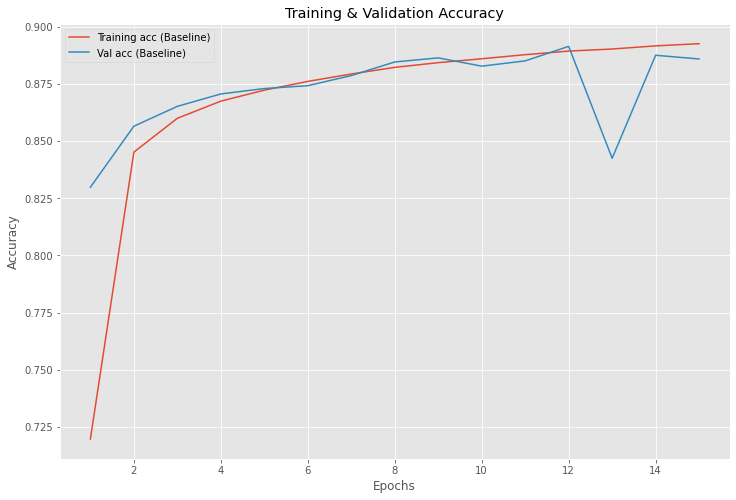

In [134]:
# plot training vs. validation accuracy
baseline_model_dict = baseline_history.history
baseline_acc_values = baseline_model_dict['acc']
baseline_val_acc_values = baseline_model_dict['val_acc']

fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(baseline_acc_values) + 1)
ax.plot(epochs, baseline_acc_values, label='Training acc (Baseline)')
ax.plot(epochs, baseline_val_acc_values, label='Val acc (Baseline)')
ax.set_title('Training & Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

In [135]:
# L2 Regularization to try and improve results
L2_model = models.Sequential()

# add input and first hidden layer
L2_model.add(layers.Dense(100, 
                          activation='relu', 
                          kernel_regularizer=regularizers.l2(0.005),
                          input_shape=(20,)))

# addditional hidden layers
L2_model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
L2_model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
L2_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
L2_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005)))

# output layer
L2_model.add(layers.Dense(1, activation='sigmoid'))

# compile model
L2_model.compile(optimizer='SGD',
                 loss='binary_crossentropy', 
                 metrics=['acc'])

In [136]:
# fit to training set
L2_history = L2_model.fit(X_train_final, y_train_final,
                          epochs=15,
                          batch_size=256,
                          validation_data=(X_test_final, y_test_final))

Train on 407606 samples, validate on 135869 samples
Epoch 1/15
407606/407606 [==============================] - 17s 41us/step - loss: 2.0431 - acc: 0.7295 - val_loss: 1.7058 - val_acc: 0.8130
Epoch 2/15
407606/407606 [==============================] - 16s 40us/step - loss: 1.4913 - acc: 0.8390 - val_loss: 1.3142 - val_acc: 0.8508
Epoch 3/15
407606/407606 [==============================] - 16s 40us/step - loss: 1.1807 - acc: 0.8523 - val_loss: 1.0587 - val_acc: 0.8567
Epoch 4/15
407606/407606 [==============================] - 17s 40us/step - loss: 0.9622 - acc: 0.8566 - val_loss: 0.8748 - val_acc: 0.8572
Epoch 5/15
407606/407606 [==============================] - 18s 45us/step - loss: 0.8040 - acc: 0.8595 - val_loss: 0.7398 - val_acc: 0.8612
Epoch 6/15
407606/407606 [==============================] - 16s 40us/step - loss: 0.6890 - acc: 0.8620 - val_loss: 0.6416 - val_acc: 0.8632
Epoch 7/15
407606/407606 [==============================] - 17s 41us/step - loss: 0.6048 - acc: 0.8639 - val

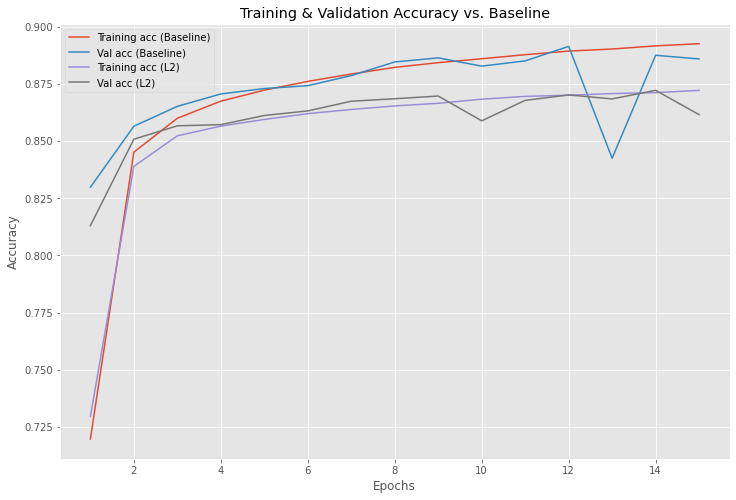

In [137]:
# plot against baseline
L2_dict = L2_history.history
L2_acc_values = L2_dict['acc']
L2_val_acc_values = L2_dict['val_acc']

fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(baseline_acc_values) + 1)
ax.plot(epochs, baseline_acc_values, label='Training acc (Baseline)')
ax.plot(epochs, baseline_val_acc_values, label='Val acc (Baseline)')
ax.plot(epochs, L2_acc_values, label='Training acc (L2)')
ax.plot(epochs, L2_val_acc_values, label='Val acc (L2)')
ax.set_title('Training & Validation Accuracy vs. Baseline')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

Comparing our regularized results vs. the baseline, we can see baseline results were stronger. Compare results using l1 regularization.

In [138]:
# L1 Regularization to try and improve results
L1_model = models.Sequential()

# add input and first hidden layer
L1_model.add(layers.Dense(100, 
                          activation='relu', 
                          kernel_regularizer=regularizers.l1(0.005),
                          input_shape=(20,)))

# addditional hidden layers
L1_model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
L1_model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
L1_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
L1_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005)))

# output layer
L1_model.add(layers.Dense(1, activation='sigmoid'))

# compile model
L1_model.compile(optimizer='SGD',
                 loss='binary_crossentropy', 
                 metrics=['acc'])

In [139]:
# fit to training set
L1_history = L1_model.fit(X_train_final, y_train_final,
                          epochs=15,
                          batch_size=256,
                          validation_data=(X_test_final, y_test_final))

Train on 407606 samples, validate on 135869 samples
Epoch 1/15
407606/407606 [==============================] - 19s 48us/step - loss: 9.4834 - acc: 0.6676 - val_loss: 5.3226 - val_acc: 0.7003
Epoch 2/15
407606/407606 [==============================] - 19s 47us/step - loss: 2.8978 - acc: 0.7089 - val_loss: 1.2632 - val_acc: 0.7255
Epoch 3/15
407606/407606 [==============================] - 20s 49us/step - loss: 0.8401 - acc: 0.7346 - val_loss: 0.6287 - val_acc: 0.7834
Epoch 4/15
407606/407606 [==============================] - 21s 52us/step - loss: 0.5425 - acc: 0.8161 - val_loss: 0.5035 - val_acc: 0.8244
Epoch 5/15
407606/407606 [==============================] - 23s 55us/step - loss: 0.4889 - acc: 0.8254 - val_loss: 0.4772 - val_acc: 0.8263
Epoch 6/15
407606/407606 [==============================] - 24s 58us/step - loss: 0.4695 - acc: 0.8276 - val_loss: 0.4630 - val_acc: 0.8291
Epoch 7/15
407606/407606 [==============================] - 19s 45us/step - loss: 0.4585 - acc: 0.8293 - val

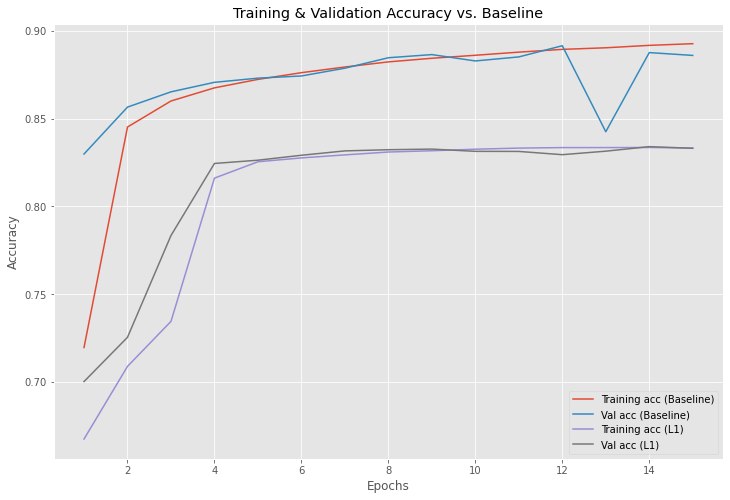

In [140]:
# plot against baseline
L1_dict = L1_history.history
L1_acc_values = L1_dict['acc']
L1_val_acc_values = L1_dict['val_acc']

fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(baseline_acc_values) + 1)
ax.plot(epochs, baseline_acc_values, label='Training acc (Baseline)')
ax.plot(epochs, baseline_val_acc_values, label='Val acc (Baseline)')
ax.plot(epochs, L1_acc_values, label='Training acc (L1)')
ax.plot(epochs, L1_val_acc_values, label='Val acc (L1)')
ax.set_title('Training & Validation Accuracy vs. Baseline')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()

Baseline is still outperforming - - will move forward without regularization.  Model is not overfitting, but performance is still looking better with our random forest

# 5. Evaluation
4 different models were evaluated, including: Decision Trees, Random Forests, XGBoost, and Neural Networks. A baseline with no hyperparameter tuning was generated for each model prior to grid search to find the optimal hyperparameters.

In [141]:
# instantiate best overall (random forest)
best_overall = RandomForestClassifier(random_state=SEED, 
                                      class_weight='balanced', 
                                      n_jobs=-1, 
                                      criterion='gini', 
                                      max_depth=15, 
                                      min_samples_leaf=1, 
                                      min_samples_split=2)

best_overall.fit(X_train_final, y_train_final)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=23)

In [142]:
# print and score results
best_results = print_model_scores(X_train_final, X_test_final,
                                  y_train_final, y_test_final,
                                  best_overall, 'best_overall')

Accuracy:
Training Set: 0.9408325687060544
Testing Set: 0.9329722011643569
---------------------------
Precision:
Training Set: 0.9033858173317082
Testing Set: 0.8954539322811278
---------------------------
Recall:
Training Set: 0.9742704298497492
Testing Set: 0.9655428774606458
---------------------------
F1 Score:
Training Set: 0.9374901182185058
Testing Set: 0.9291785583750028
---------------------------
ROC AUC:
Training Set: 0.9435710681208401
Test Set: 0.9356398757868808


Summarizing the performance metrics of our final model, we see the following scores:
- Accuracy: 93%, meaning our model assigns the correct label 93% of th etime.  A significant improvement over a "dummy" model with accuracy of ~55%. 
- Precision: 89%, meaning if our model labels a data point as fishing, there is a 89% chance it is really fishing. 
- Recall: 96%, meaning that of all data points actually labeled as fishing, our model was able to correctly identify 96% of them.
- F1 Score: 93%. Represents harmonic mean between recall and precision.  
- ROC AUC: 0.93, represents the area under the ROC curve. A perfect score is 1. 

While there is some room for improvement, these scores are strong.  The time it takes to train our final selected model is fairly trivial, even with tuning of hyperparams. 

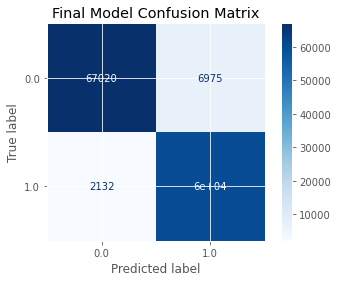

In [143]:
# plot confusion matrix of final model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(best_overall,
                      X_test_final,
                      y_test,
                      cmap=plt.cm.Blues)
plt.title('Final Model Confusion Matrix')
plt.show()

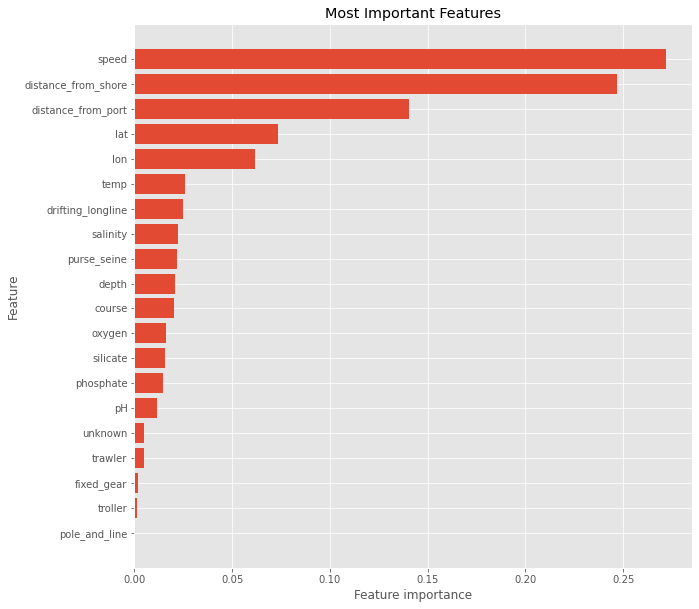

In [144]:
# plot feature importance of final model
plot_feature_importances(best_overall, X_train_final, y_train_final)

Looking at top feature importances, we see speed is the most important feature, followed by distance_from_shore, distance_from_port, lat, lon.  Also nice to see some of the ocean station data measurements in there, like temp, salinity, depth, oxygen, silicate, etc.  Overall, very strong performance.  

Given strong results, regulators and policy makers could use this classifier in conjunction with public AIS and Ocean Station Data to monitor vessels in real-time when physical monitoring is not possible.  Additionally, coordinates of vessels marked as fishing could be cross-checked against restricted areas to help identify illegal / unregulated fishing activity. 

# Conclusion
Given the strong results of our classifier, I suggest the following recommendations:
1. Use classifier in conjunction with public AIS data to start tagging ships as fishing or not
2. Cross reference vessels labeled as fishing with illegal fishing zones, regulated areas, etc.
3. Physically search ships arriving at port that have been flagged as potential violators. 4. Track ships engaged in fishing activity to better understand favorable conditions / areas to better understand fisherman behavior